In [53]:
import pickle, os, gzip, json
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import pynndescent
from sklearn.feature_extraction.text import TfidfTransformer
import umap
import scipy as sp

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300

import sys
sys.path.append("../../scripts")

## Load data

In [22]:
import data_io
reload(data_io)
from data_io import is_fwd_id, get_fwd_id

import nearest_neighbors
reload(nearest_neighbors)
from nearest_neighbors import (
    get_overlap_candidates,
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
)

import truth
reload(truth)
from truth import get_overlaps

In [23]:
read_count = 2000

npz_path = "../../data/feature_matrix/kmer/CHM13/TRA/perfect_50k/feature_matrix.npz"
feature_matrix = sp.sparse.load_npz(npz_path)
tsv_path = "../../data/feature_matrix/kmer/CHM13/TRA/perfect_50k/metadata.tsv.gz"
meta_df = pd.read_table(tsv_path).set_index("row_id")
read_indices = {name: index for index, name in meta_df['read_name'].items()}
json_path = "../../data/feature_matrix/kmer/CHM13/TRA/perfect_50k/read_features.json.gz"
with gzip.open(json_path, 'rt') as f:
    read_features = json.load(f)

feature_matrix = feature_matrix[:read_count, :]
read_features = read_features[:read_count]
meta_df = meta_df.iloc[:read_count, :].copy()


read_features = {i: features_i for i, features_i in enumerate(read_features)}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

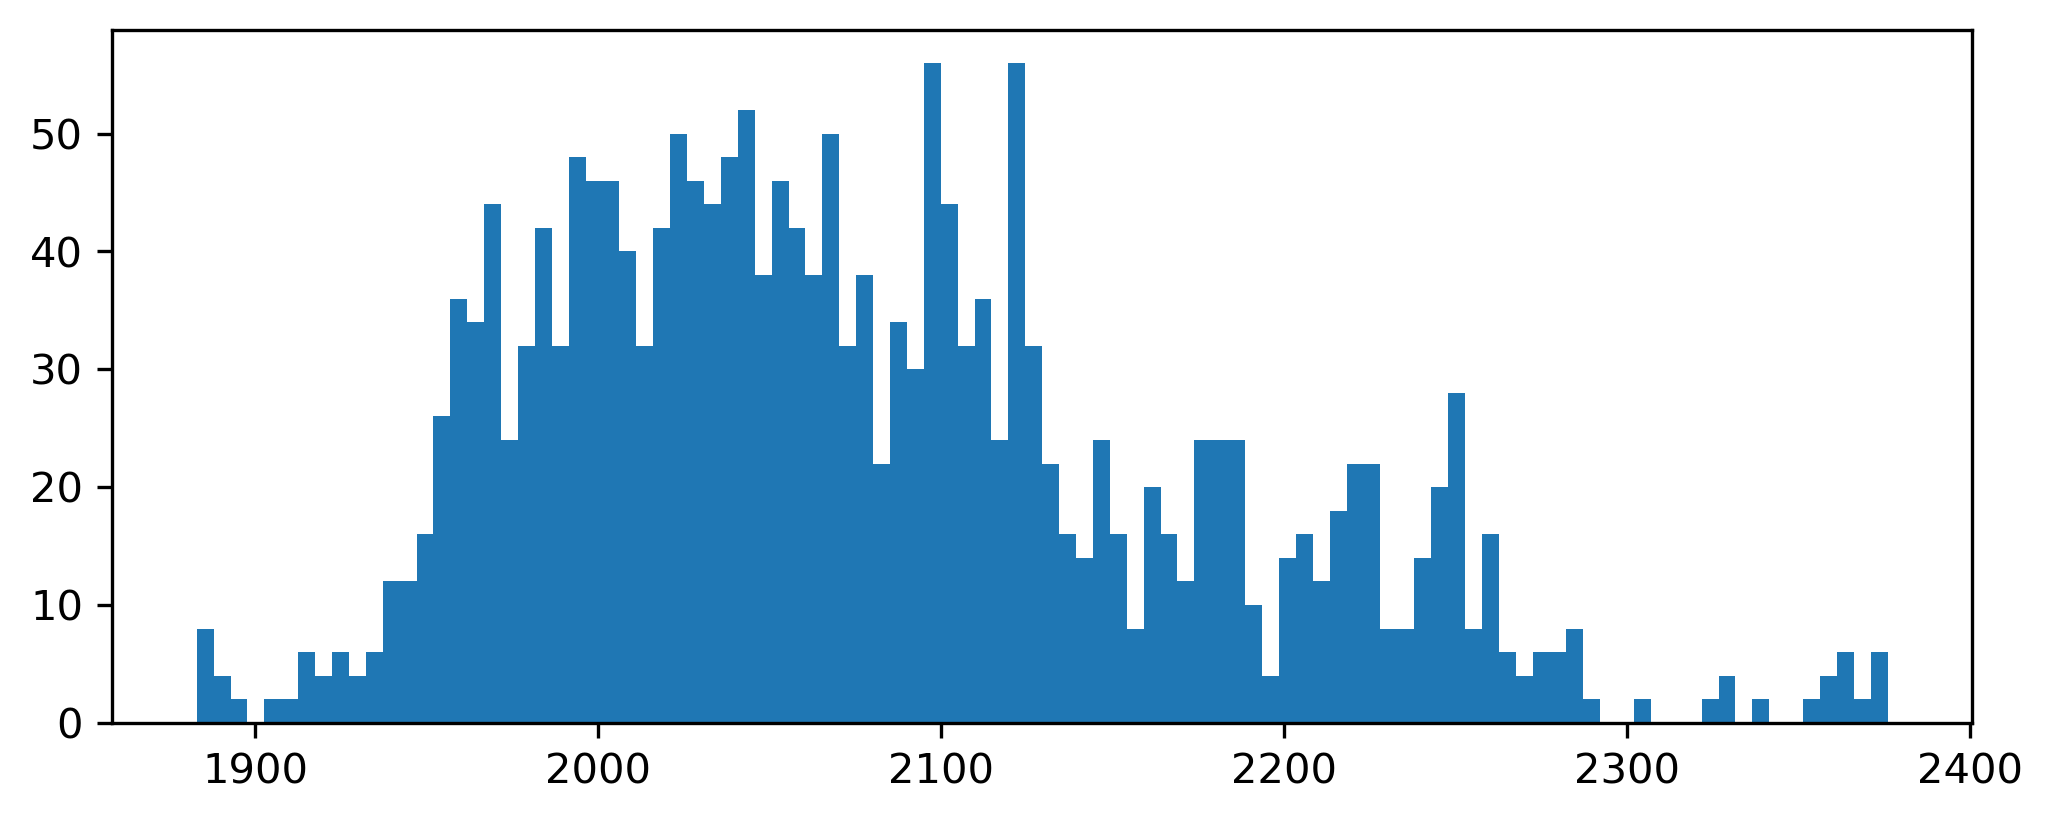

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist([len(x) for x in read_features.values()], bins=100);

In [25]:
feature_matrix.shape

(2000, 32096)

In [26]:
meta_df

read_name strand  read_length    start      end
row_id                                                 
0        389206_R      +        50000   389206   439206
1        389206_R      -        50000   389206   439206
2        776466_F      +        50000   776466   826466
3        776466_F      -        50000   776466   826466
4       1838660_F      +        50000  1838660  1888660
...           ...    ...          ...      ...      ...
1995    2743046_F      -        50000  2743046  2793046
1996    1045226_R      +        50000  1045226  1095226
1997    1045226_R      -        50000  1045226  1095226
1998     817421_F      +        50000   817421   867421
1999     817421_F      -        50000   817421   867421

[2000 rows x 5 columns]

In [32]:
pickle_file = "data/pickle/true_overlaps.pickle.gz"
use_pickle = False

if os.path.isfile(pickle_file) and use_pickle:
    with gzip.open(pickle_file, "rb") as f:
        true_overlaps = pickle.load(f)
else:
    interval_dict = {
        index: [(0, row["start"], row["end"])] for index, row in meta_df.iterrows()
    }
    true_overlaps = get_overlaps(interval_dict)

    if use_pickle:
        with gzip.open(pickle_file, "wb") as f:
            pickle.dump(true_overlaps, f)


0 1000 

## Get nearest neighbours

In [33]:
import nearest_neighbors
reload(nearest_neighbors)
from nearest_neighbors import (
    get_overlap_candidates,
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    _NearestNeighbors
)

In [34]:
import evaluate
reload(evaluate)
from evaluate import NearestNeighborsConfig

In [48]:
config_list = [
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=False,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="cosine"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=24,
        kw=dict(metric="cosine"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="cosine"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=False,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=None,
        n_neighbors=24,
        kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=True,
        dim_reduction=100,
        n_neighbors=24,
        kw=dict(metric="euclidean"),
    ),
    NearestNeighborsConfig(
        method=ExactNearestNeighbors,
        use_tfidf=False,
        dim_reduction=None,
        n_neighbors=24,
        kw=dict(metric="jaccard"),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=False,
        n_neighbors=12,
        kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
    NearestNeighborsConfig(
        method=WeightedLowHash,
        use_tfidf=True,
        n_neighbors=12,
        kw=dict(
            lowhash_fraction=0.01,
            repeats=100,
            max_bucket_size=10,
            min_cooccurence_count=2,
            seed=458,
        ),
    ),
]

In [49]:
pickle_file = "data/pickle/alignment_dict.pickle.gz"
use_pickle = True

data = feature_matrix

if os.path.isfile(pickle_file) and use_pickle:
    with gzip.open(pickle_file, "rb") as f:
        alignment_dict = pickle.load(f)
else:
    alignment_dict = {}
initial_alignment_count = len(alignment_dict)

n_neighbors = 10
for config in config_list:
    print(config)
    config.run(data, list(read_features))
    config.evaluate_pre_alignment(true_overlaps=true_overlaps, n_neighbors=n_neighbors)
    print(
        "\n",
        "Pre-alignment:",
        f"{config.pre_align_precision:.3f}",
        f"{config.pre_align_recall:.3f}",
        f"{config.time:.1f}",
        len(config.overlap_candidates),
        "\n",
    )

    config.evaluate_post_alignment(
        true_overlaps=true_overlaps,
        alignment_dict=alignment_dict,
        feature_weights=feature_weights,
        read_features=read_features,
        n_neighbors=n_neighbors,
        min_alignment_score=0,
        processes=8,
    )
    print(
        "\n",
        "Post-alignment:",
        f"{config.post_align_precision:.3f}",
        f"{config.post_align_recall:.3f}",
        "\n",
    )

if use_pickle and len(alignment_dict) > initial_alignment_count:
    with gzip.open(pickle_file, "wb") as f:
        pickle.dump(alignment_dict, f)

NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=False, dim_reduction=100, n_neighbors=24, kw={'metric': 'cosine'}, time=None, pre_align_recall=None, post_align_precision=None, post_align_recall=None)

 Pre-alignment: 0.996 0.404 4.4 20554 


 Post-alignment: 1.000 0.399 

NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=True, dim_reduction=None, n_neighbors=24, kw={'metric': 'cosine'}, time=None, pre_align_recall=None, post_align_precision=None, post_align_recall=None)

 Pre-alignment: 1.000 0.400 2.5 20968 


 Post-alignment: 1.000 0.400 

NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=True, dim_reduction=100, n_neighbors=24, kw={'metric': 'cosine'}, time=None, pre_align_recall=None, post_align_precision=None, post_align_recall=None)

 Pre-alignment: 0.998 0.400 2.9 20943 

0	493.82		
 Post-alignment: 1.000 0.400 

NearestNeighborsConfig(method=<class 'neare

/home/ecs-user/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)



 Pre-alignment: 1.000 0.400 166.6 21093 

0	81.34		
 Post-alignment: 1.000 0.400 

NearestNeighborsConfig(method=<class 'nearest_neighbors.WeightedLowHash'>, use_tfidf=False, dim_reduction=None, n_neighbors=12, kw={'lowhash_fraction': 0.01, 'repeats': 100, 'max_bucket_size': 10, 'min_cooccurence_count': 2, 'seed': 458}, time=None, pre_align_recall=None, post_align_precision=None, post_align_recall=None)
0 1000 
 Pre-alignment: 0.999 0.396 23.8 10184 


 Post-alignment: 1.000 0.396 

NearestNeighborsConfig(method=<class 'nearest_neighbors.WeightedLowHash'>, use_tfidf=True, dim_reduction=None, n_neighbors=12, kw={'lowhash_fraction': 0.01, 'repeats': 100, 'max_bucket_size': 10, 'min_cooccurence_count': 2, 'seed': 458}, time=None, pre_align_recall=None, post_align_precision=None, post_align_recall=None)
0 1000 
 Pre-alignment: 0.999 0.399 23.7 10579 


 Post-alignment: 1.000 0.399 



## Visualisation

In [79]:
# Plots
import plots

reload(plots)
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

In [80]:
def plot_configs(configs, overlap_dict, **kw):
    graphs = [config.graph for config in configs]
    figures, axes = mp_plot_read_graphs(graphs, overlap_dict=overlap_dict, **kw)
    for ax, config in zip(axes, configs):
        ax.text(0, 0, str(config), ha='left', va='bottom', transform=ax.transAxes, wrap=True)
        ax.axis('off')
    return figures, axes

7 1 4 0 2 6 5 8 3 

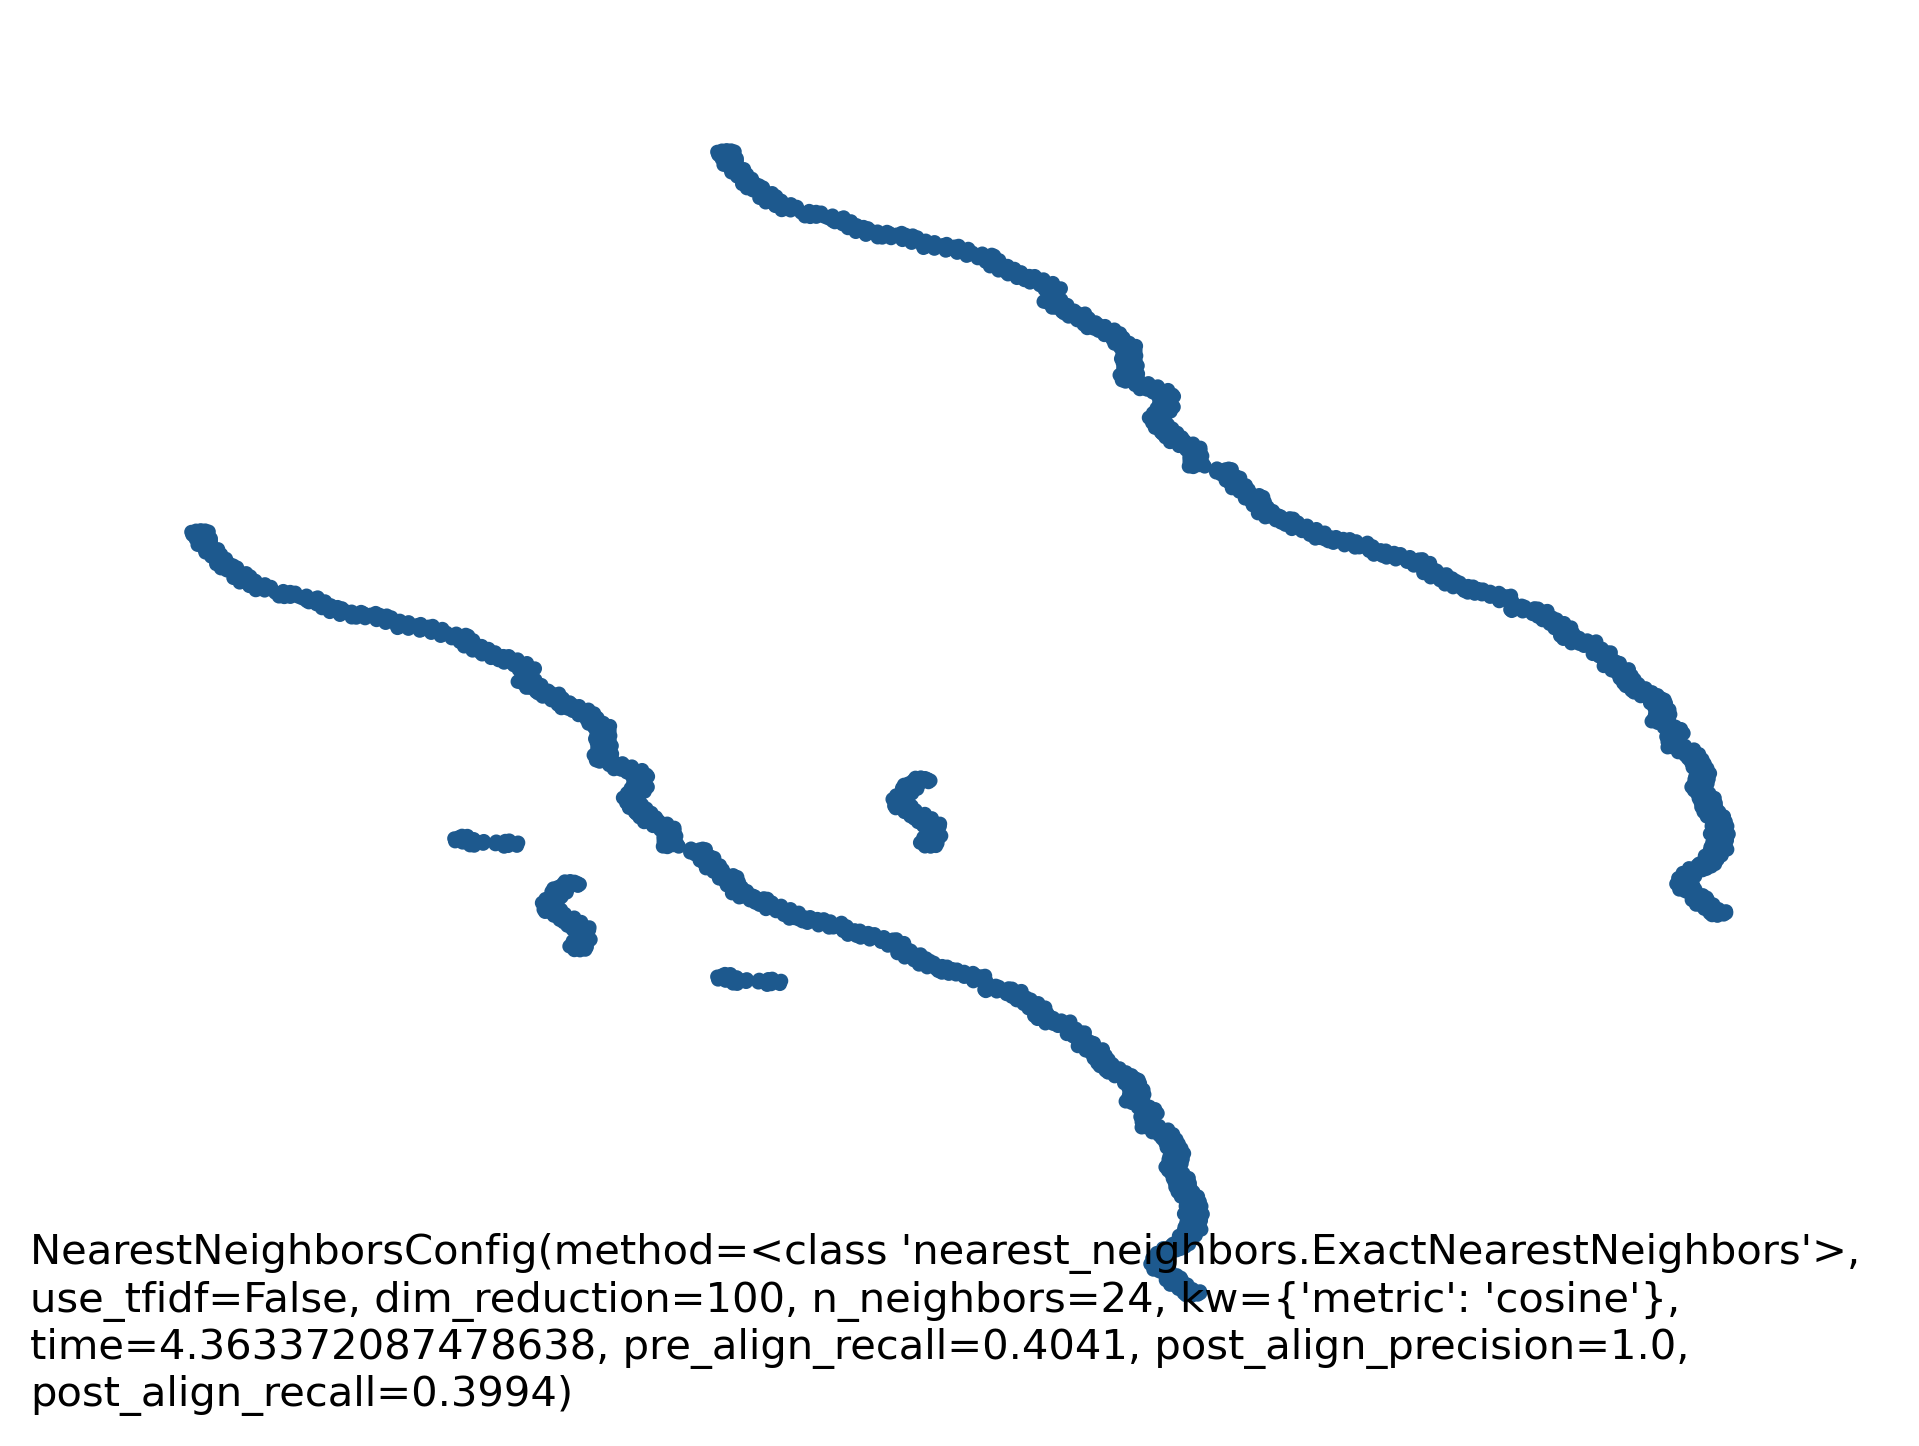

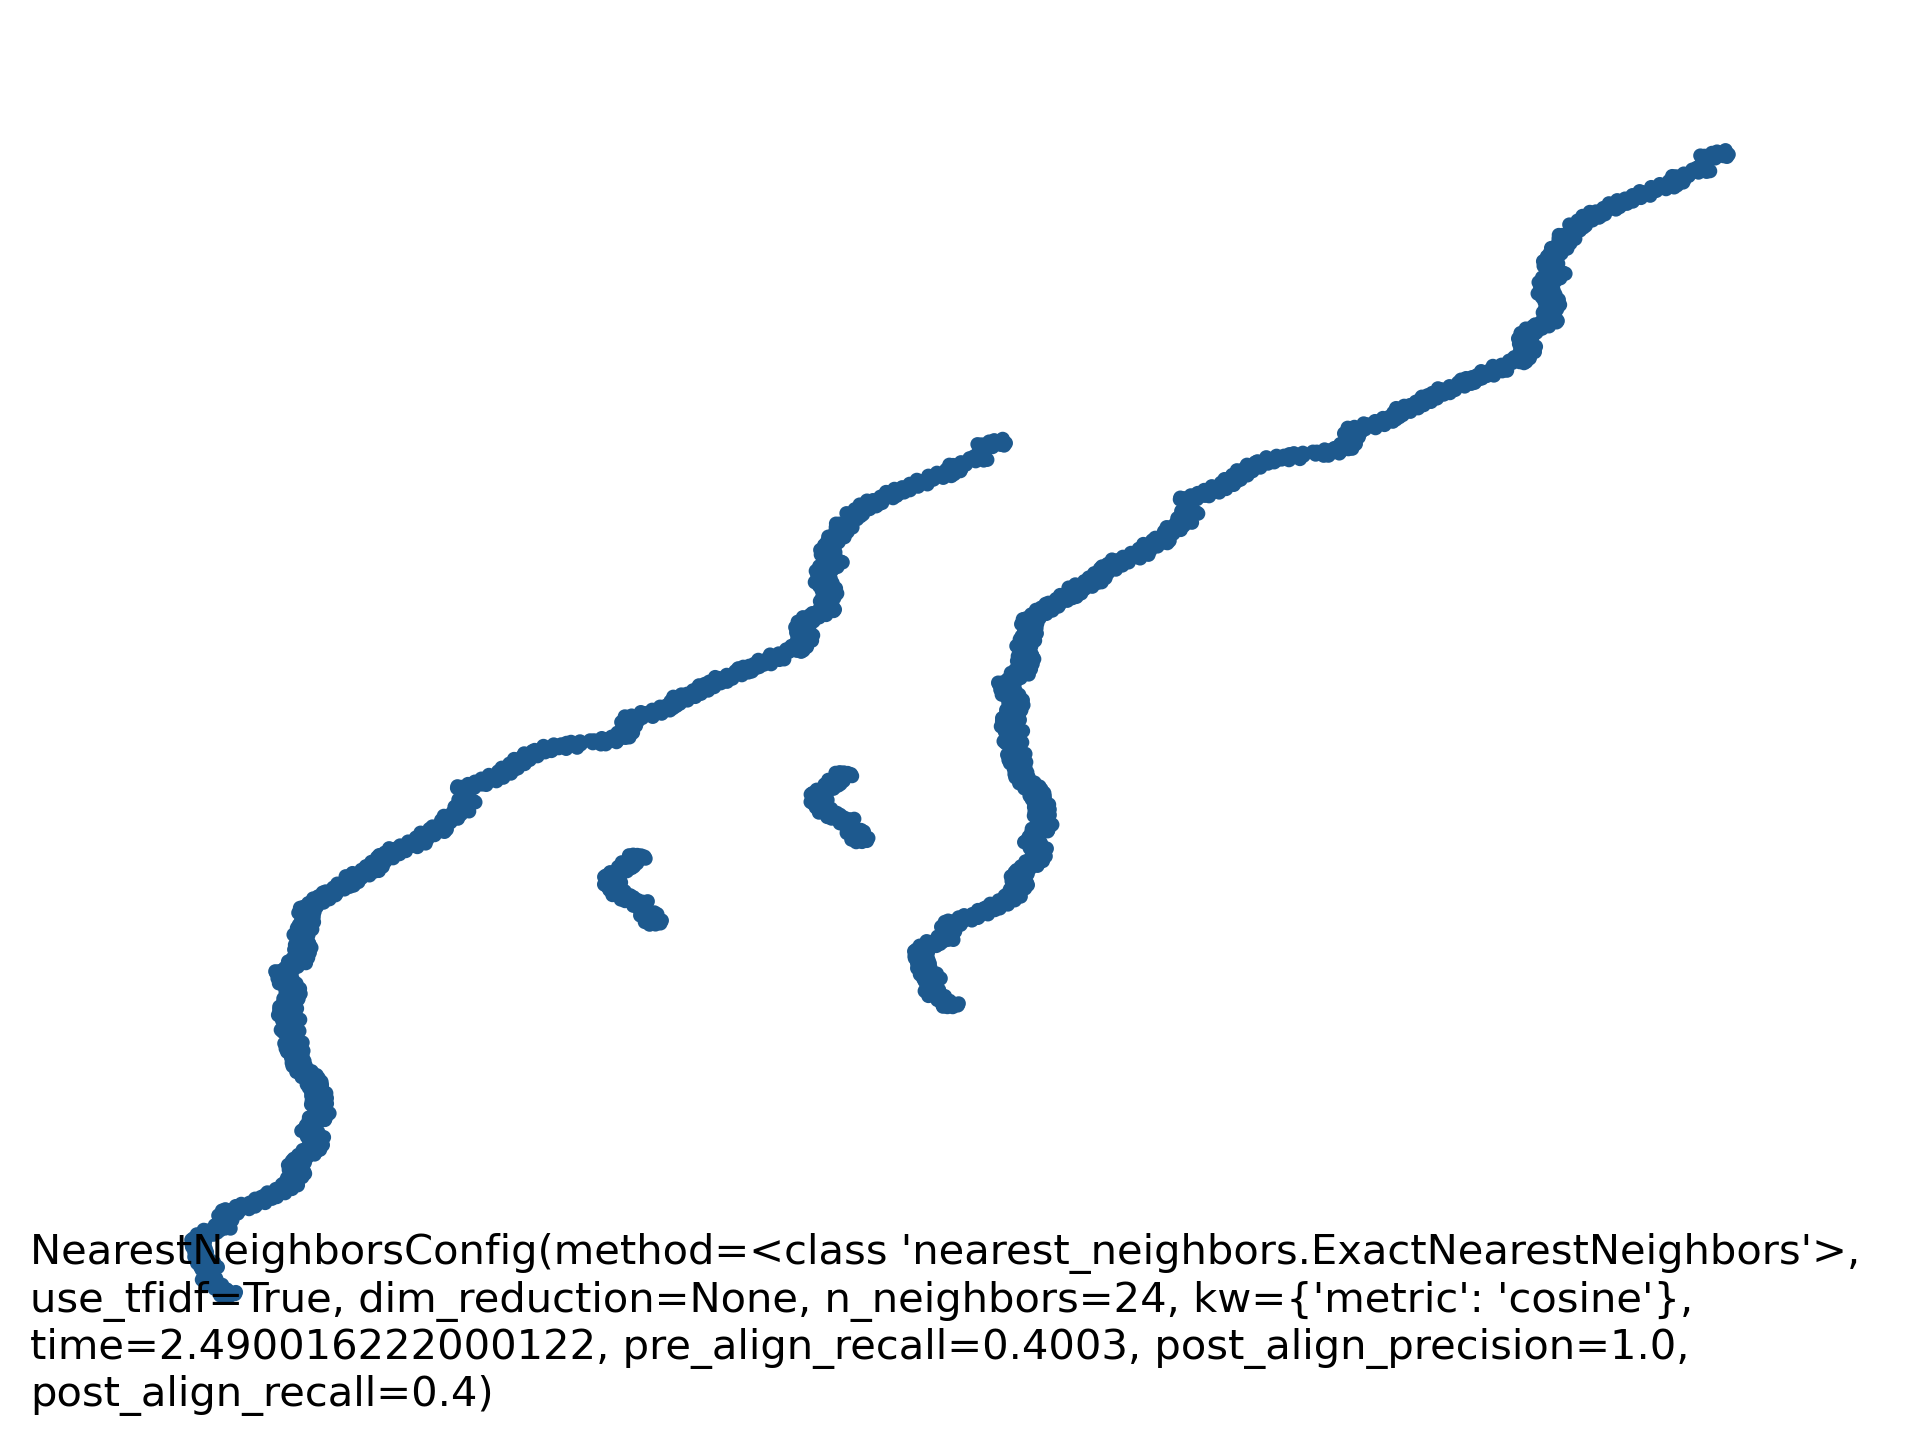

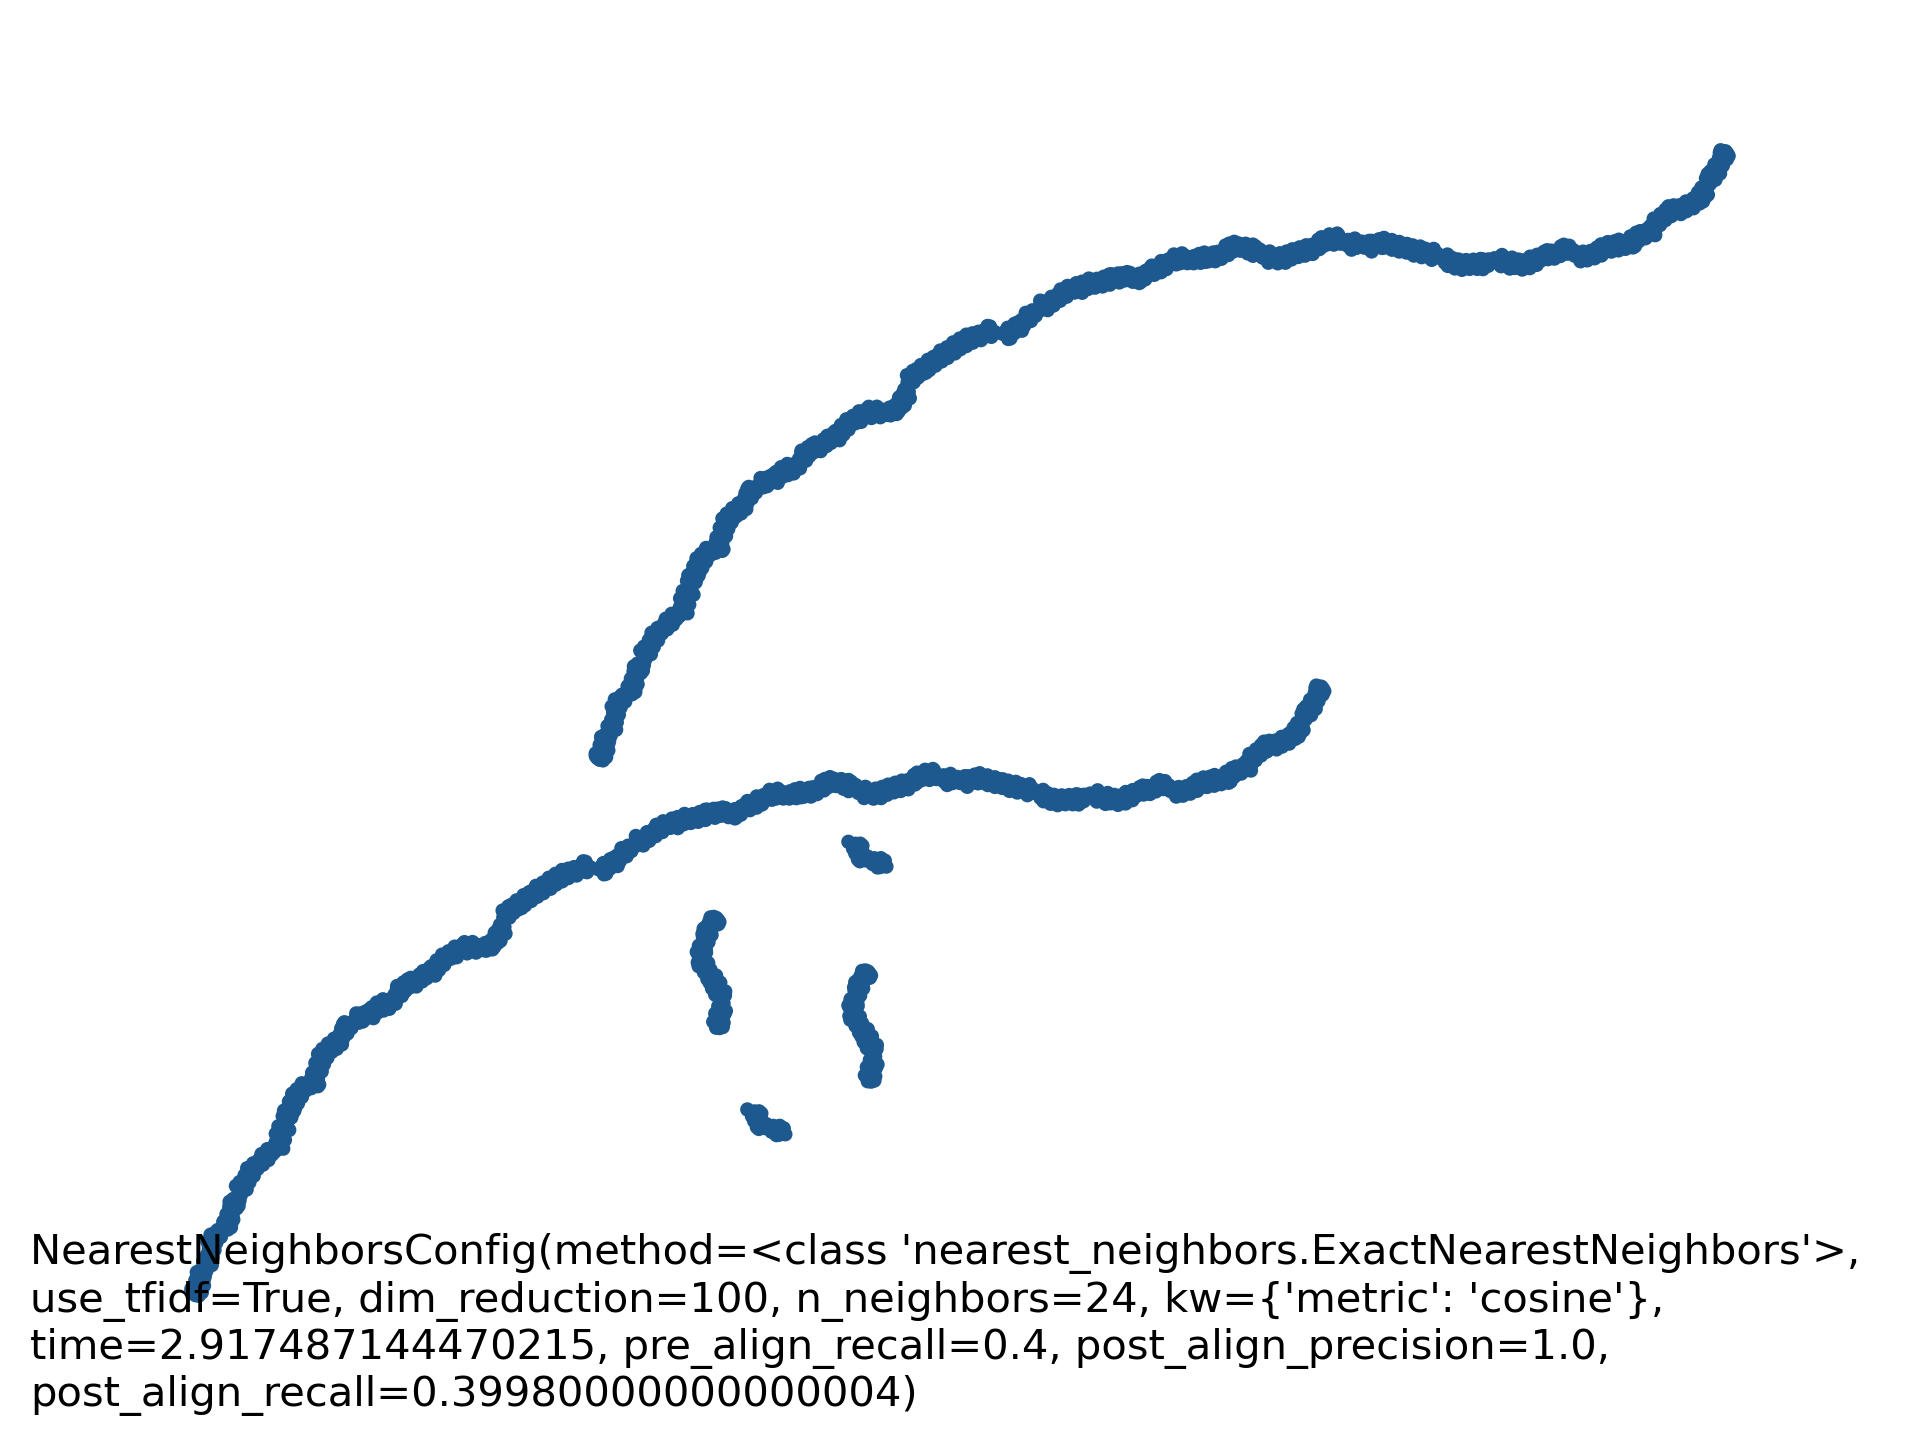

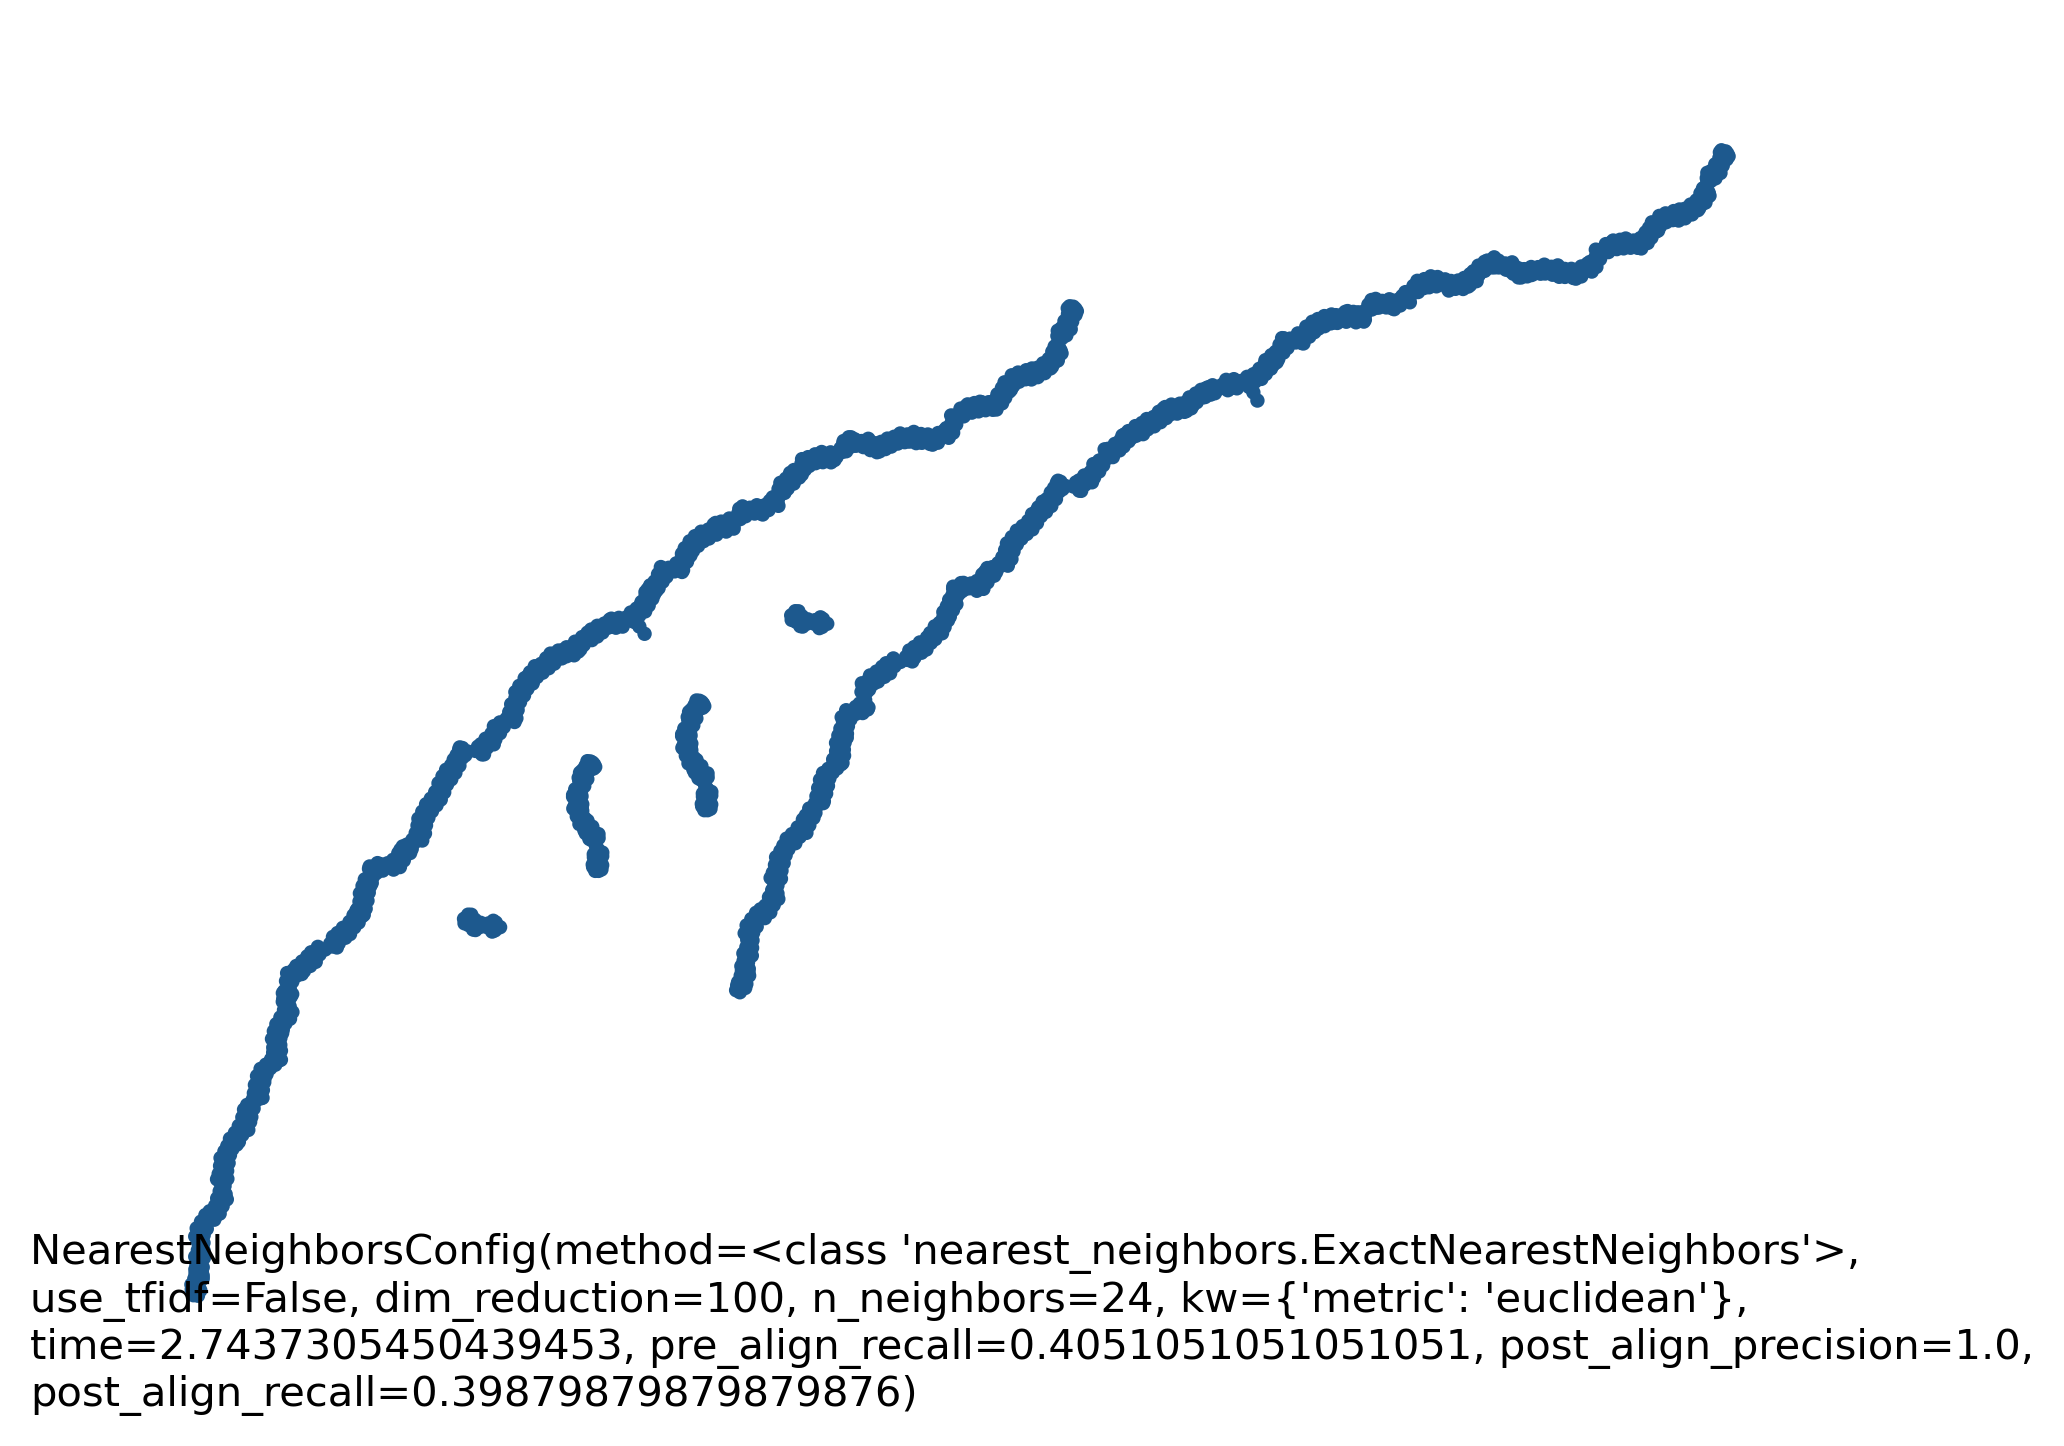

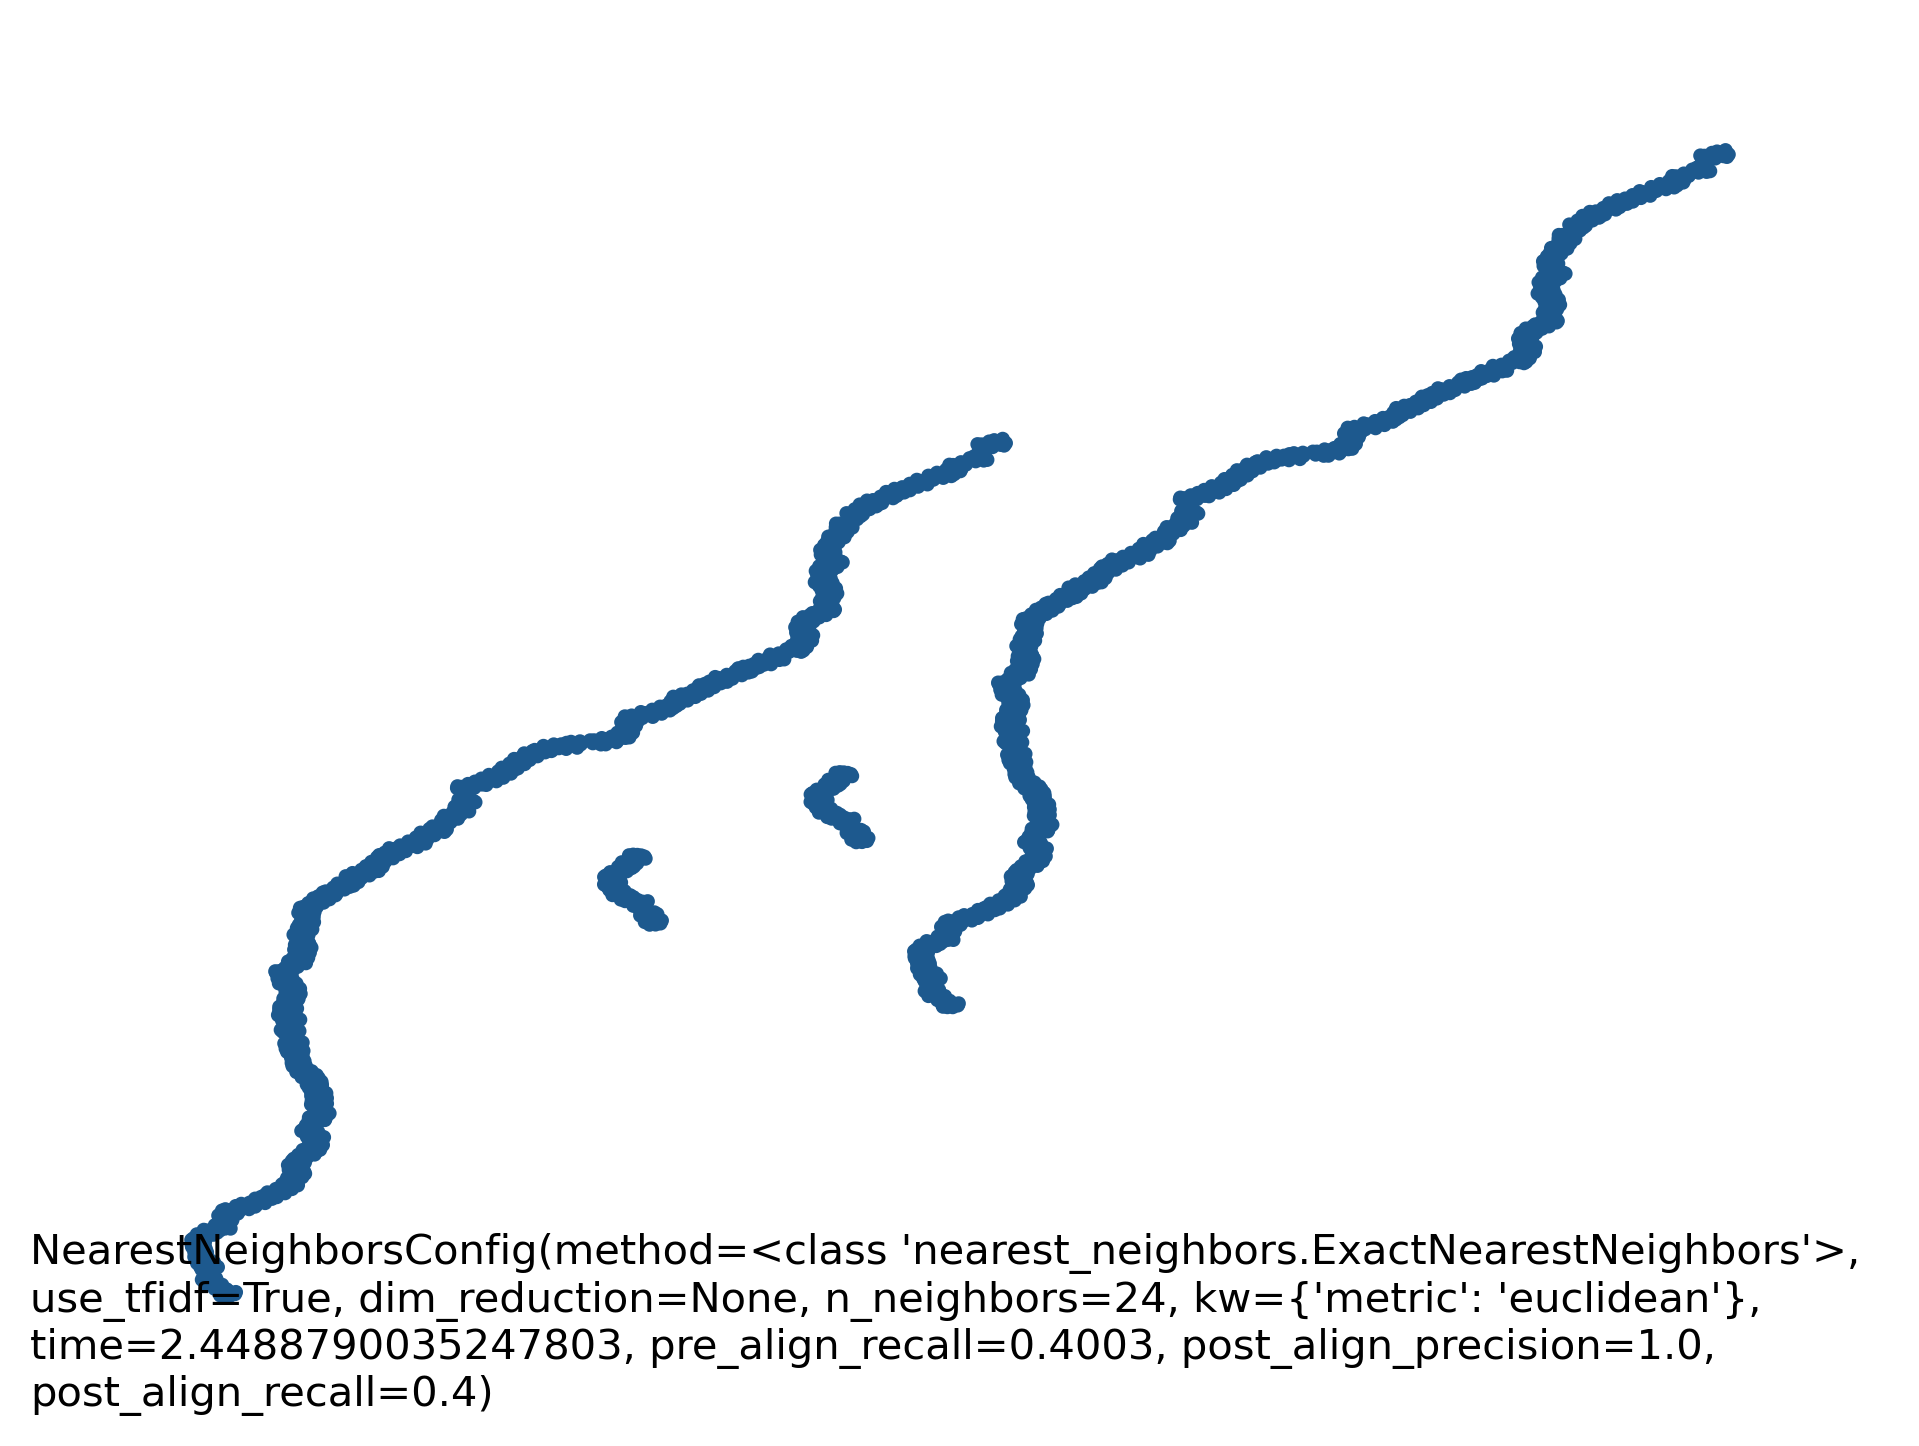

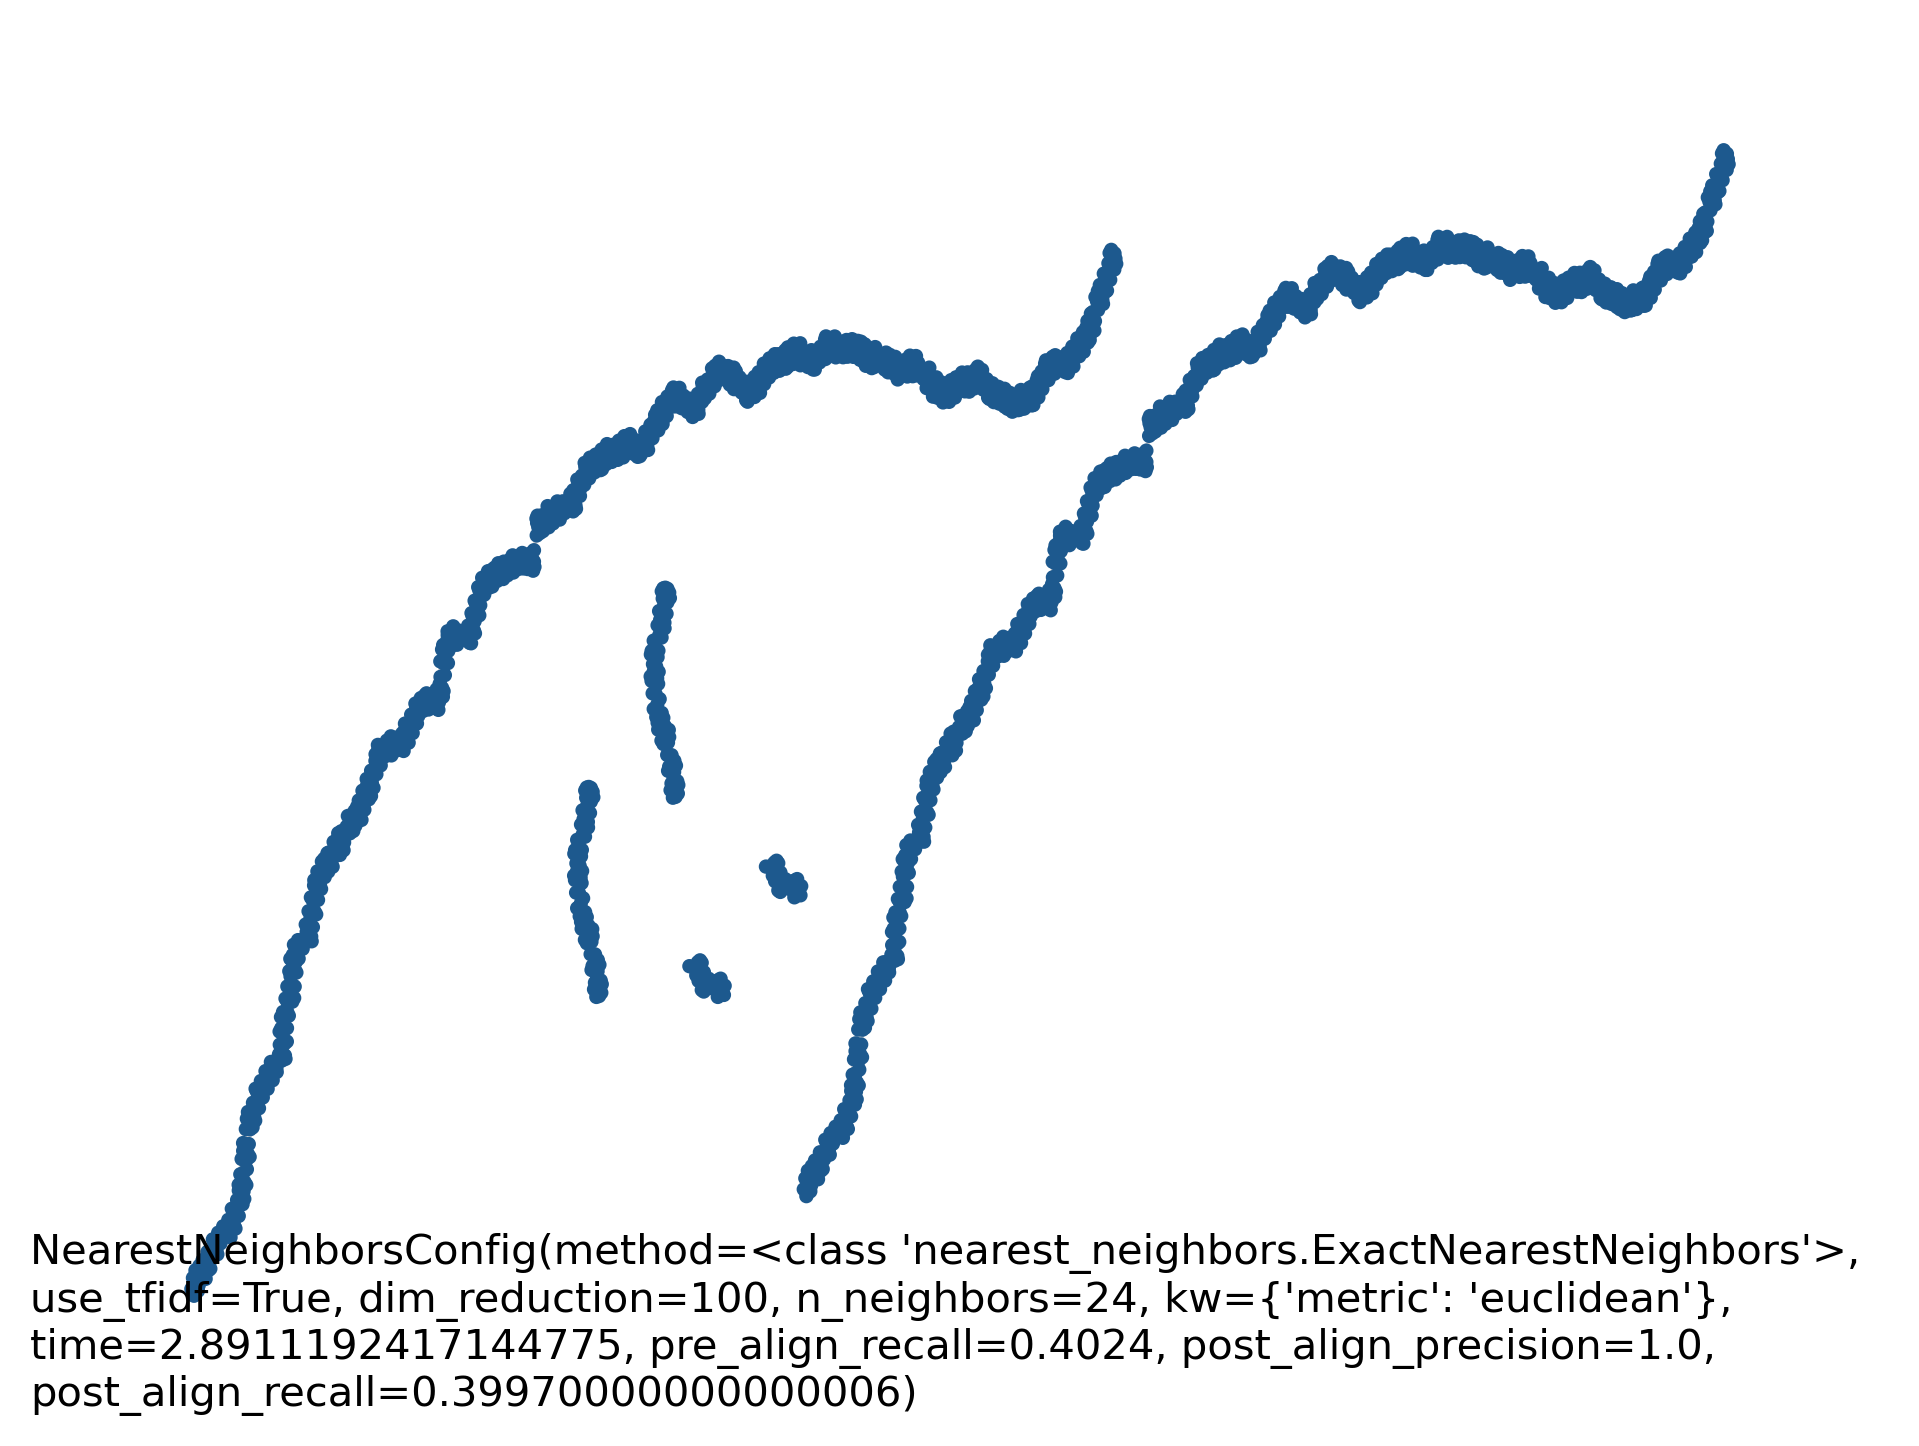

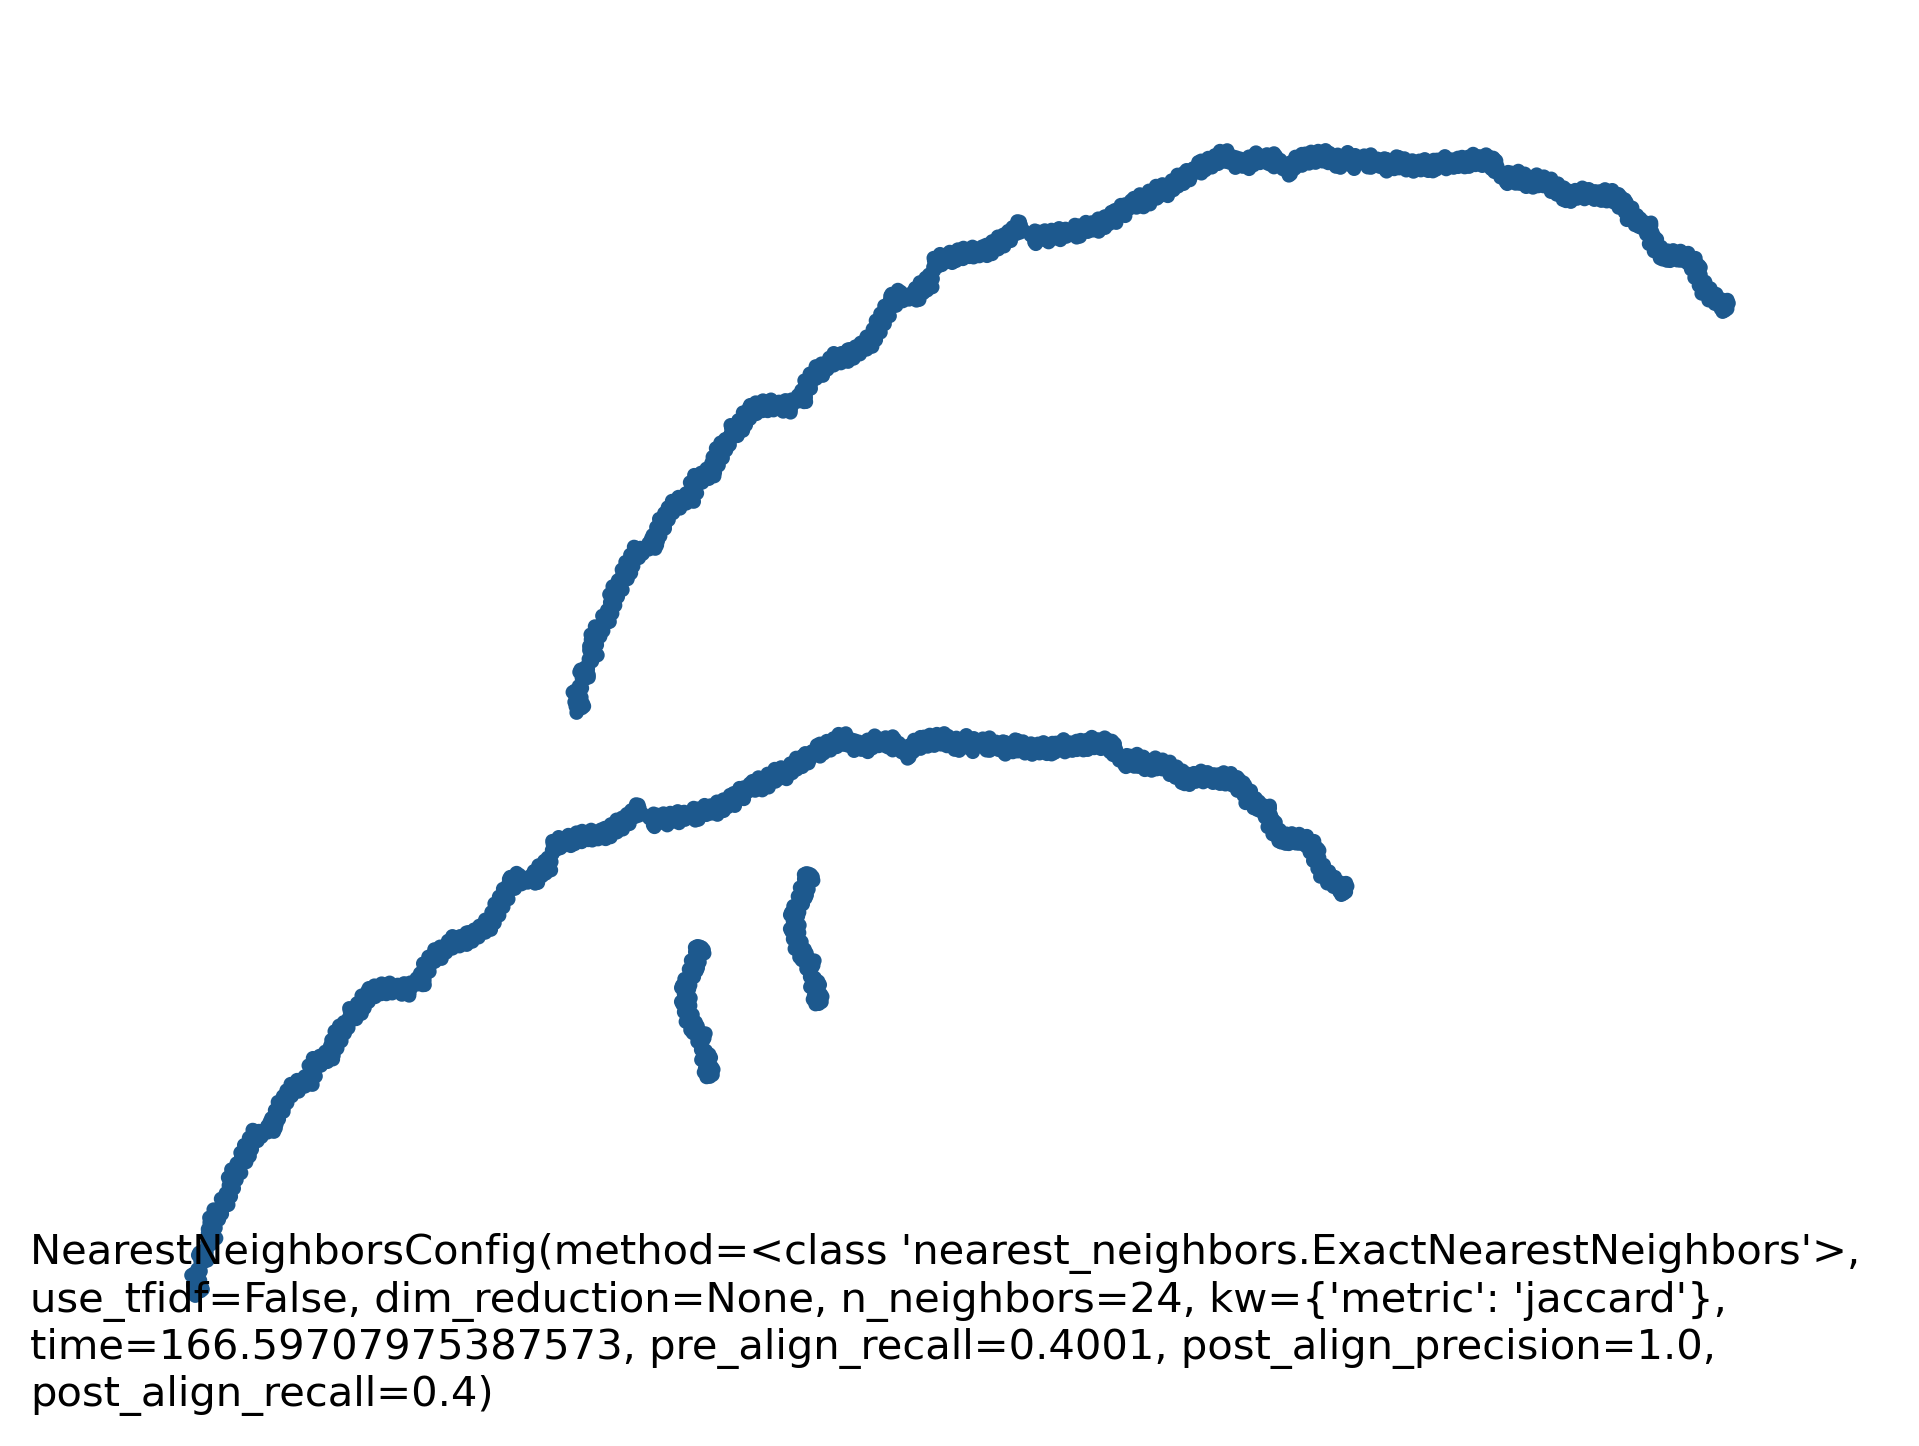

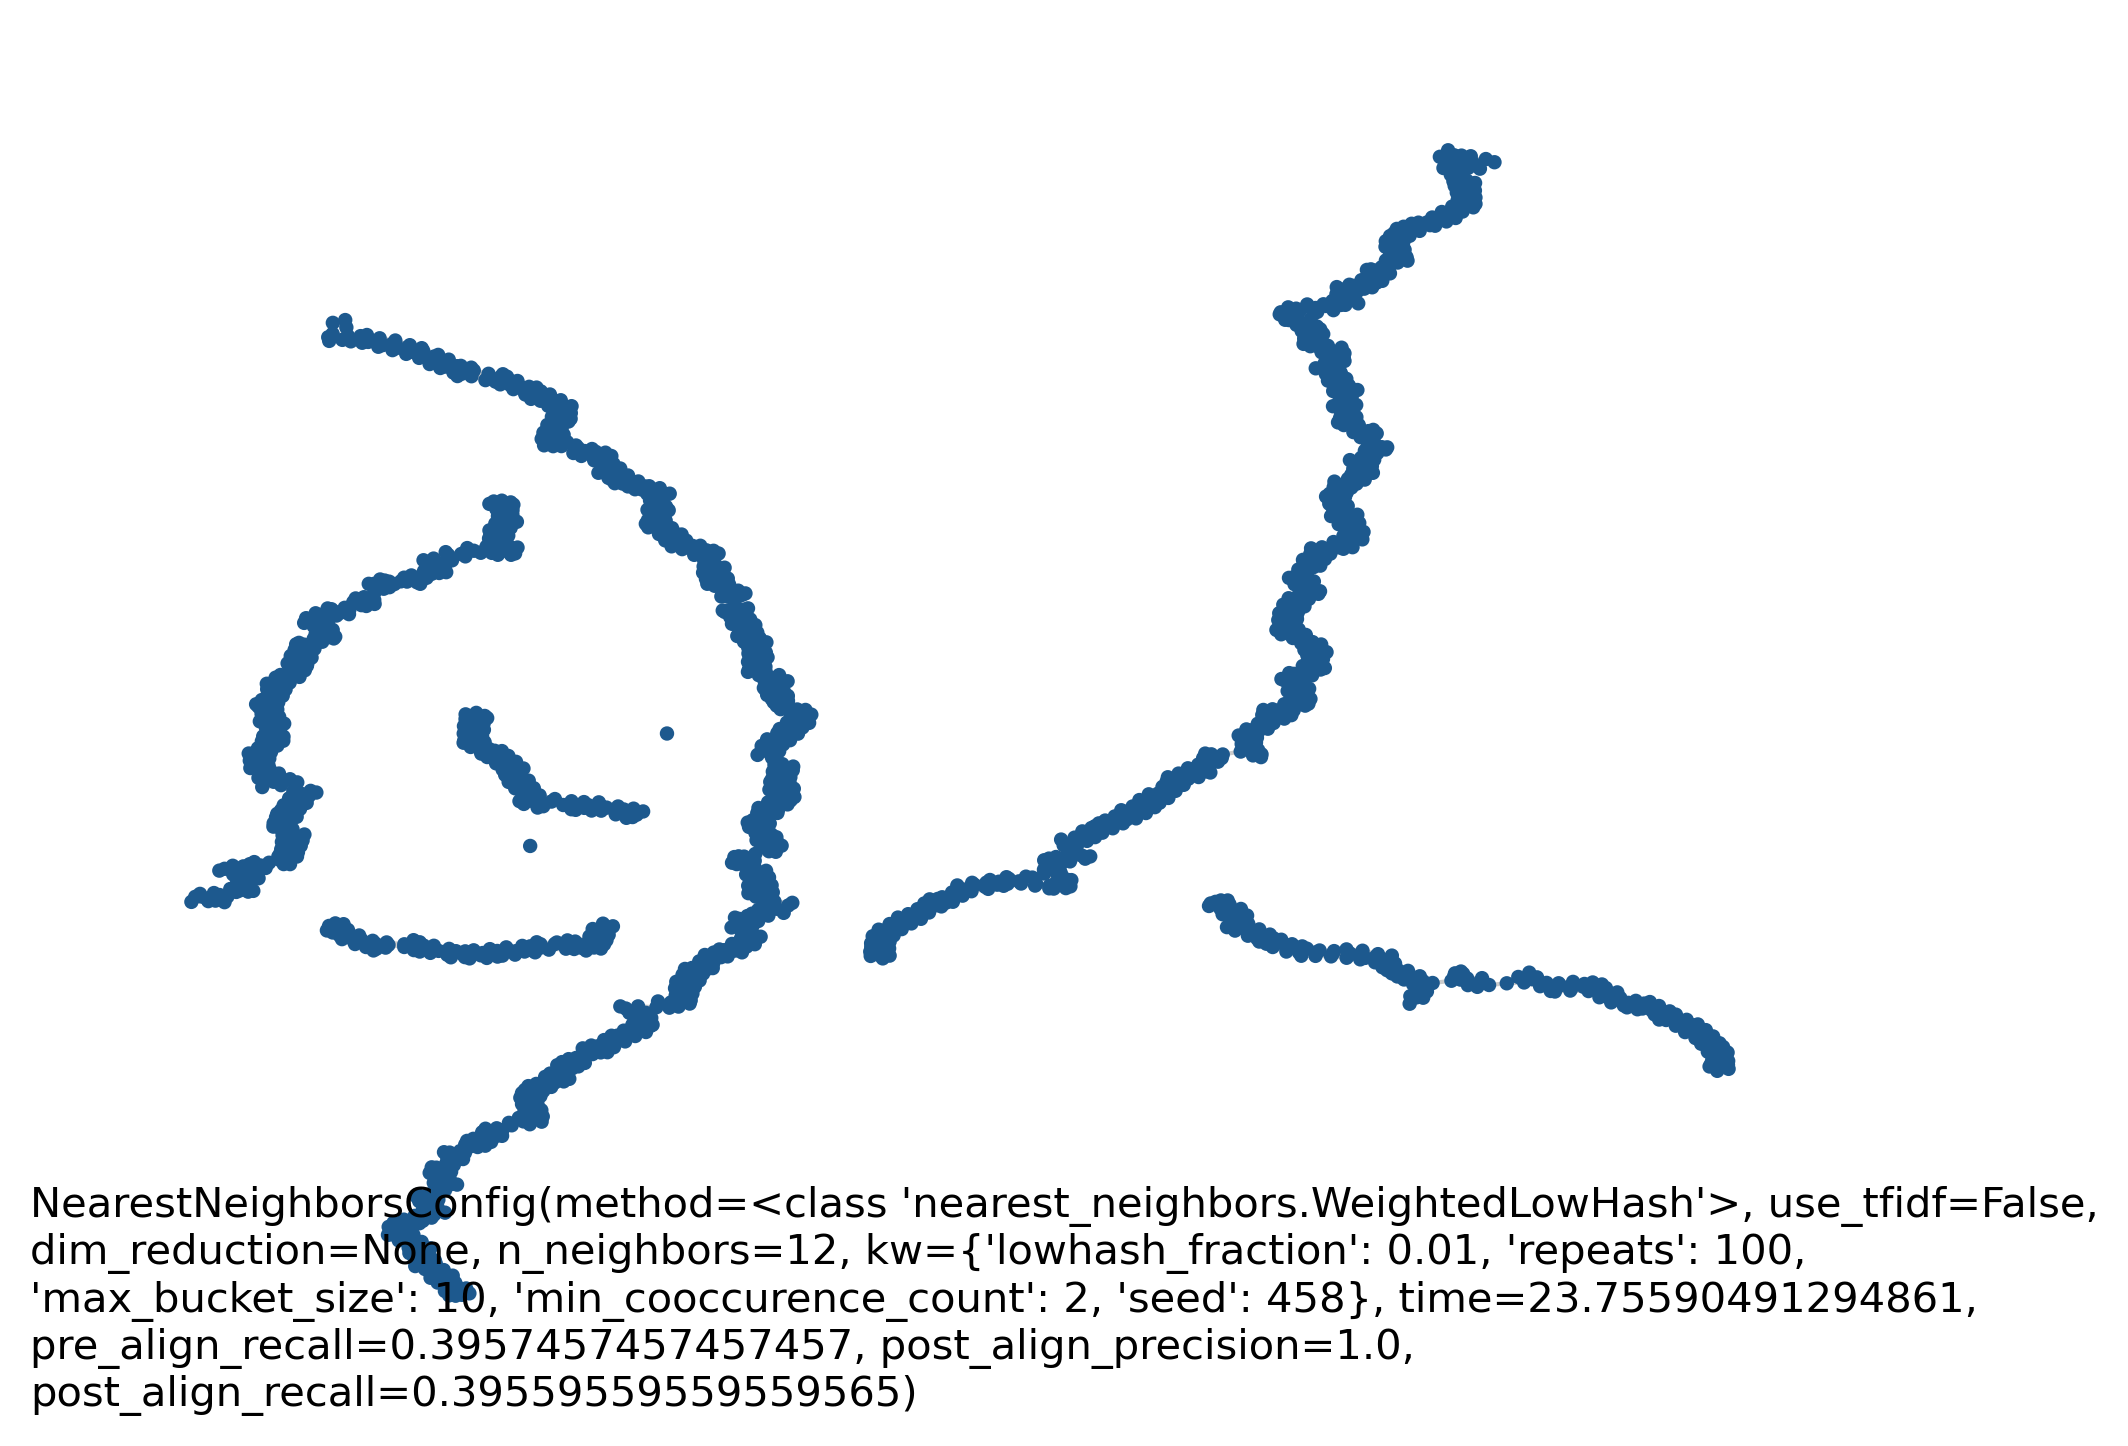

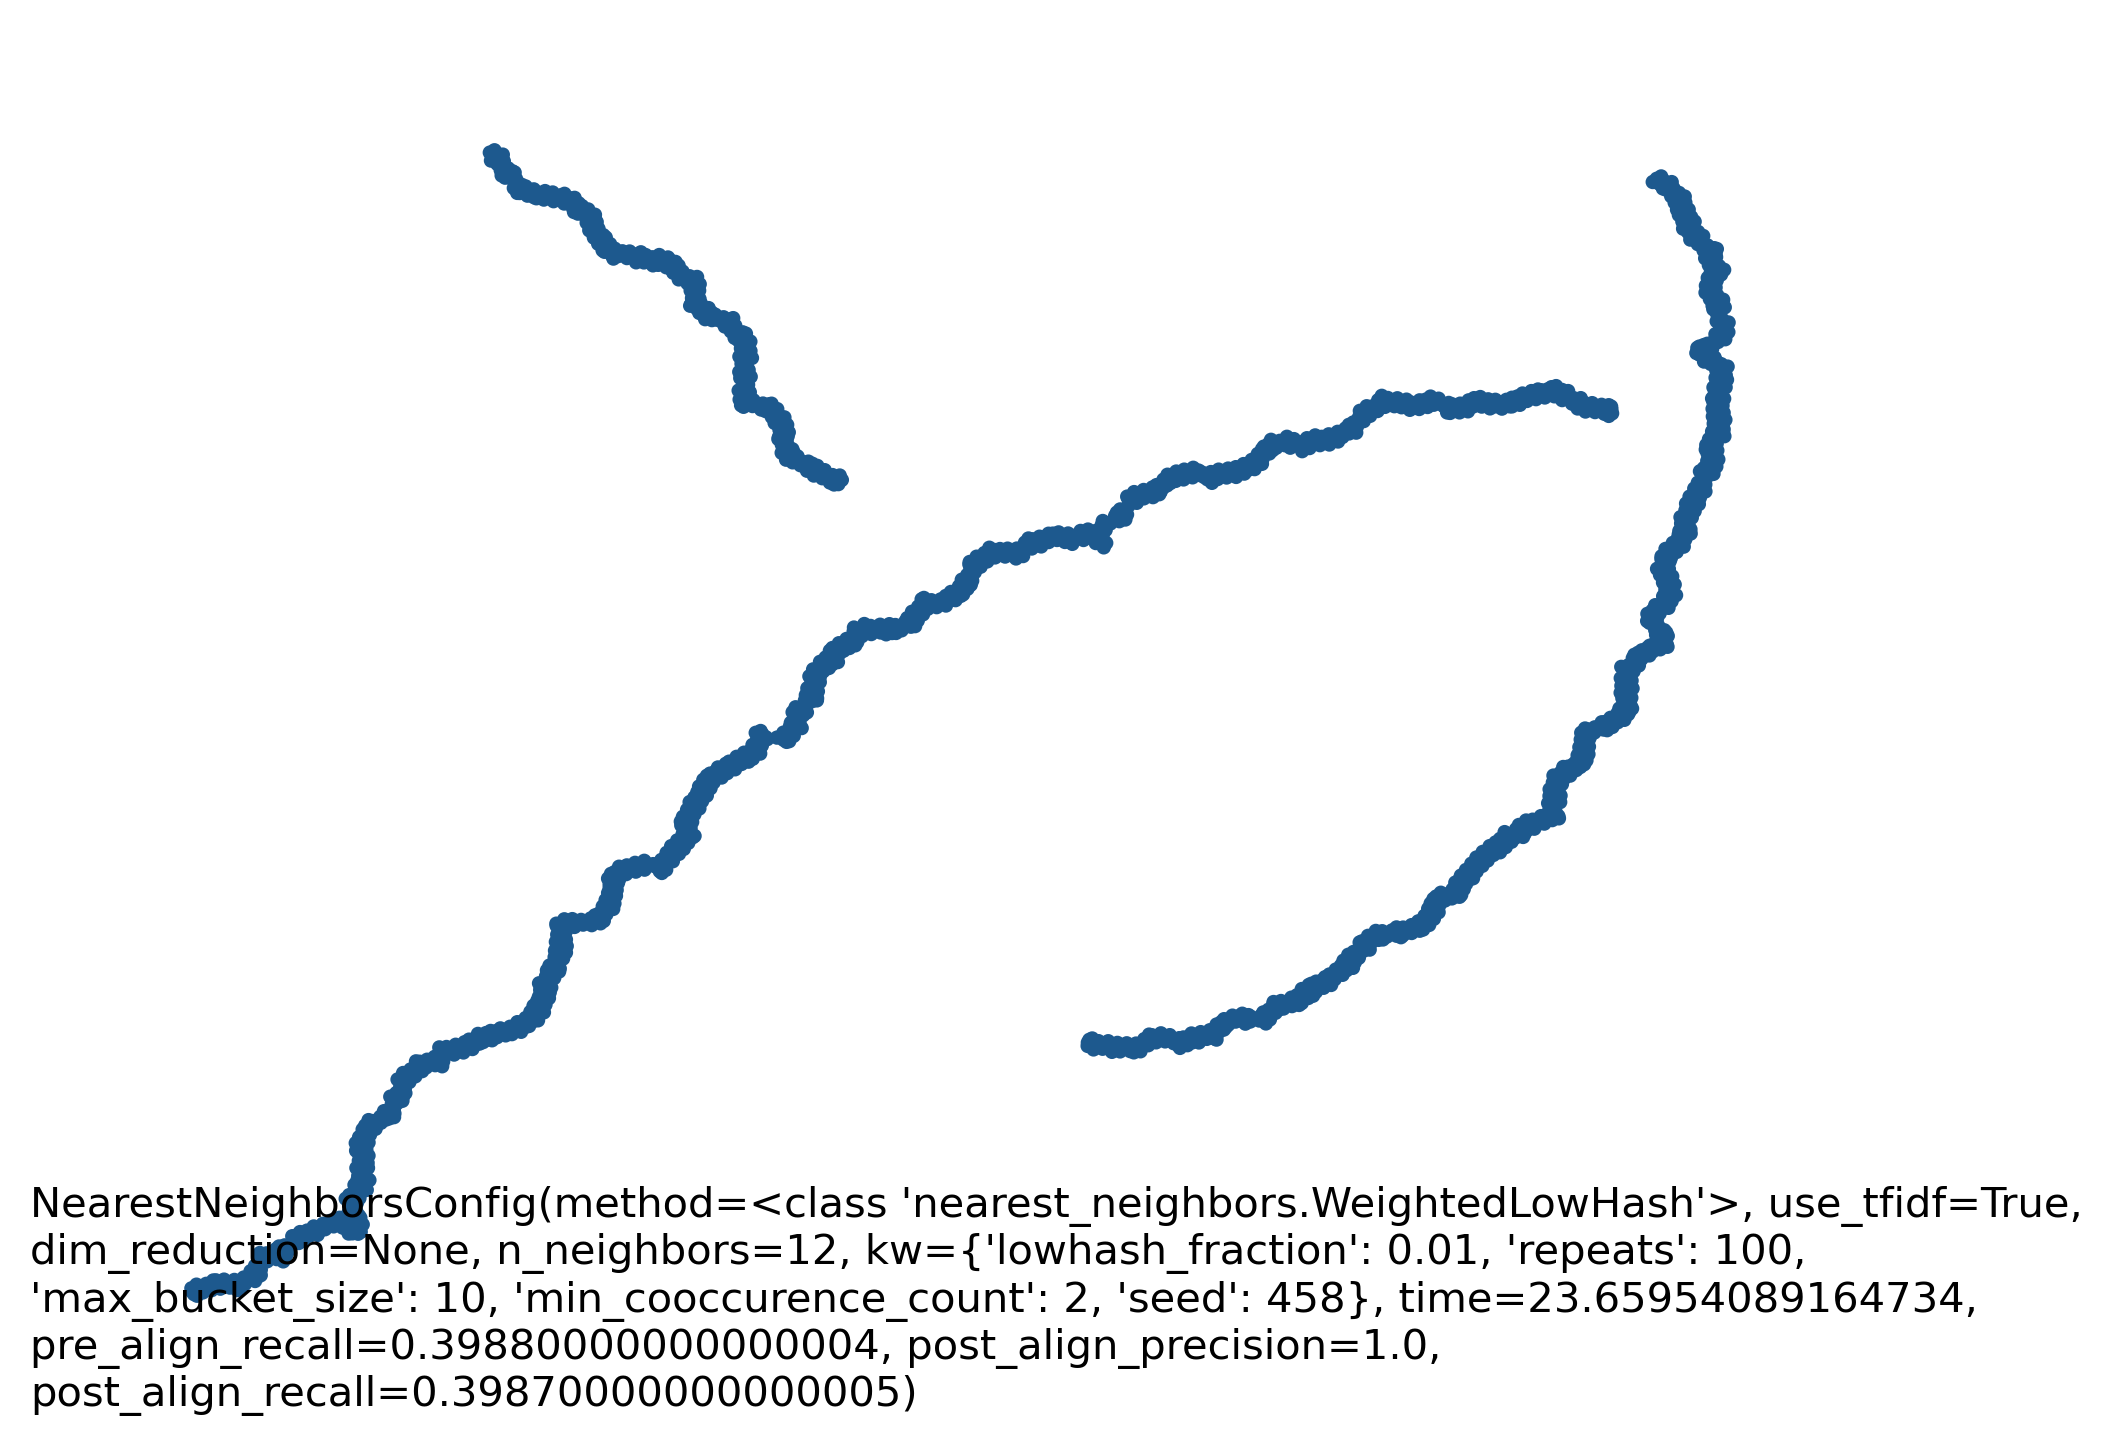

In [78]:
figures, axes = plot_configs(
    config_list, overlap_dict=true_overlaps, layout_method="neato", processes=16
)

7 8 5 0 3 2 1 4 6 

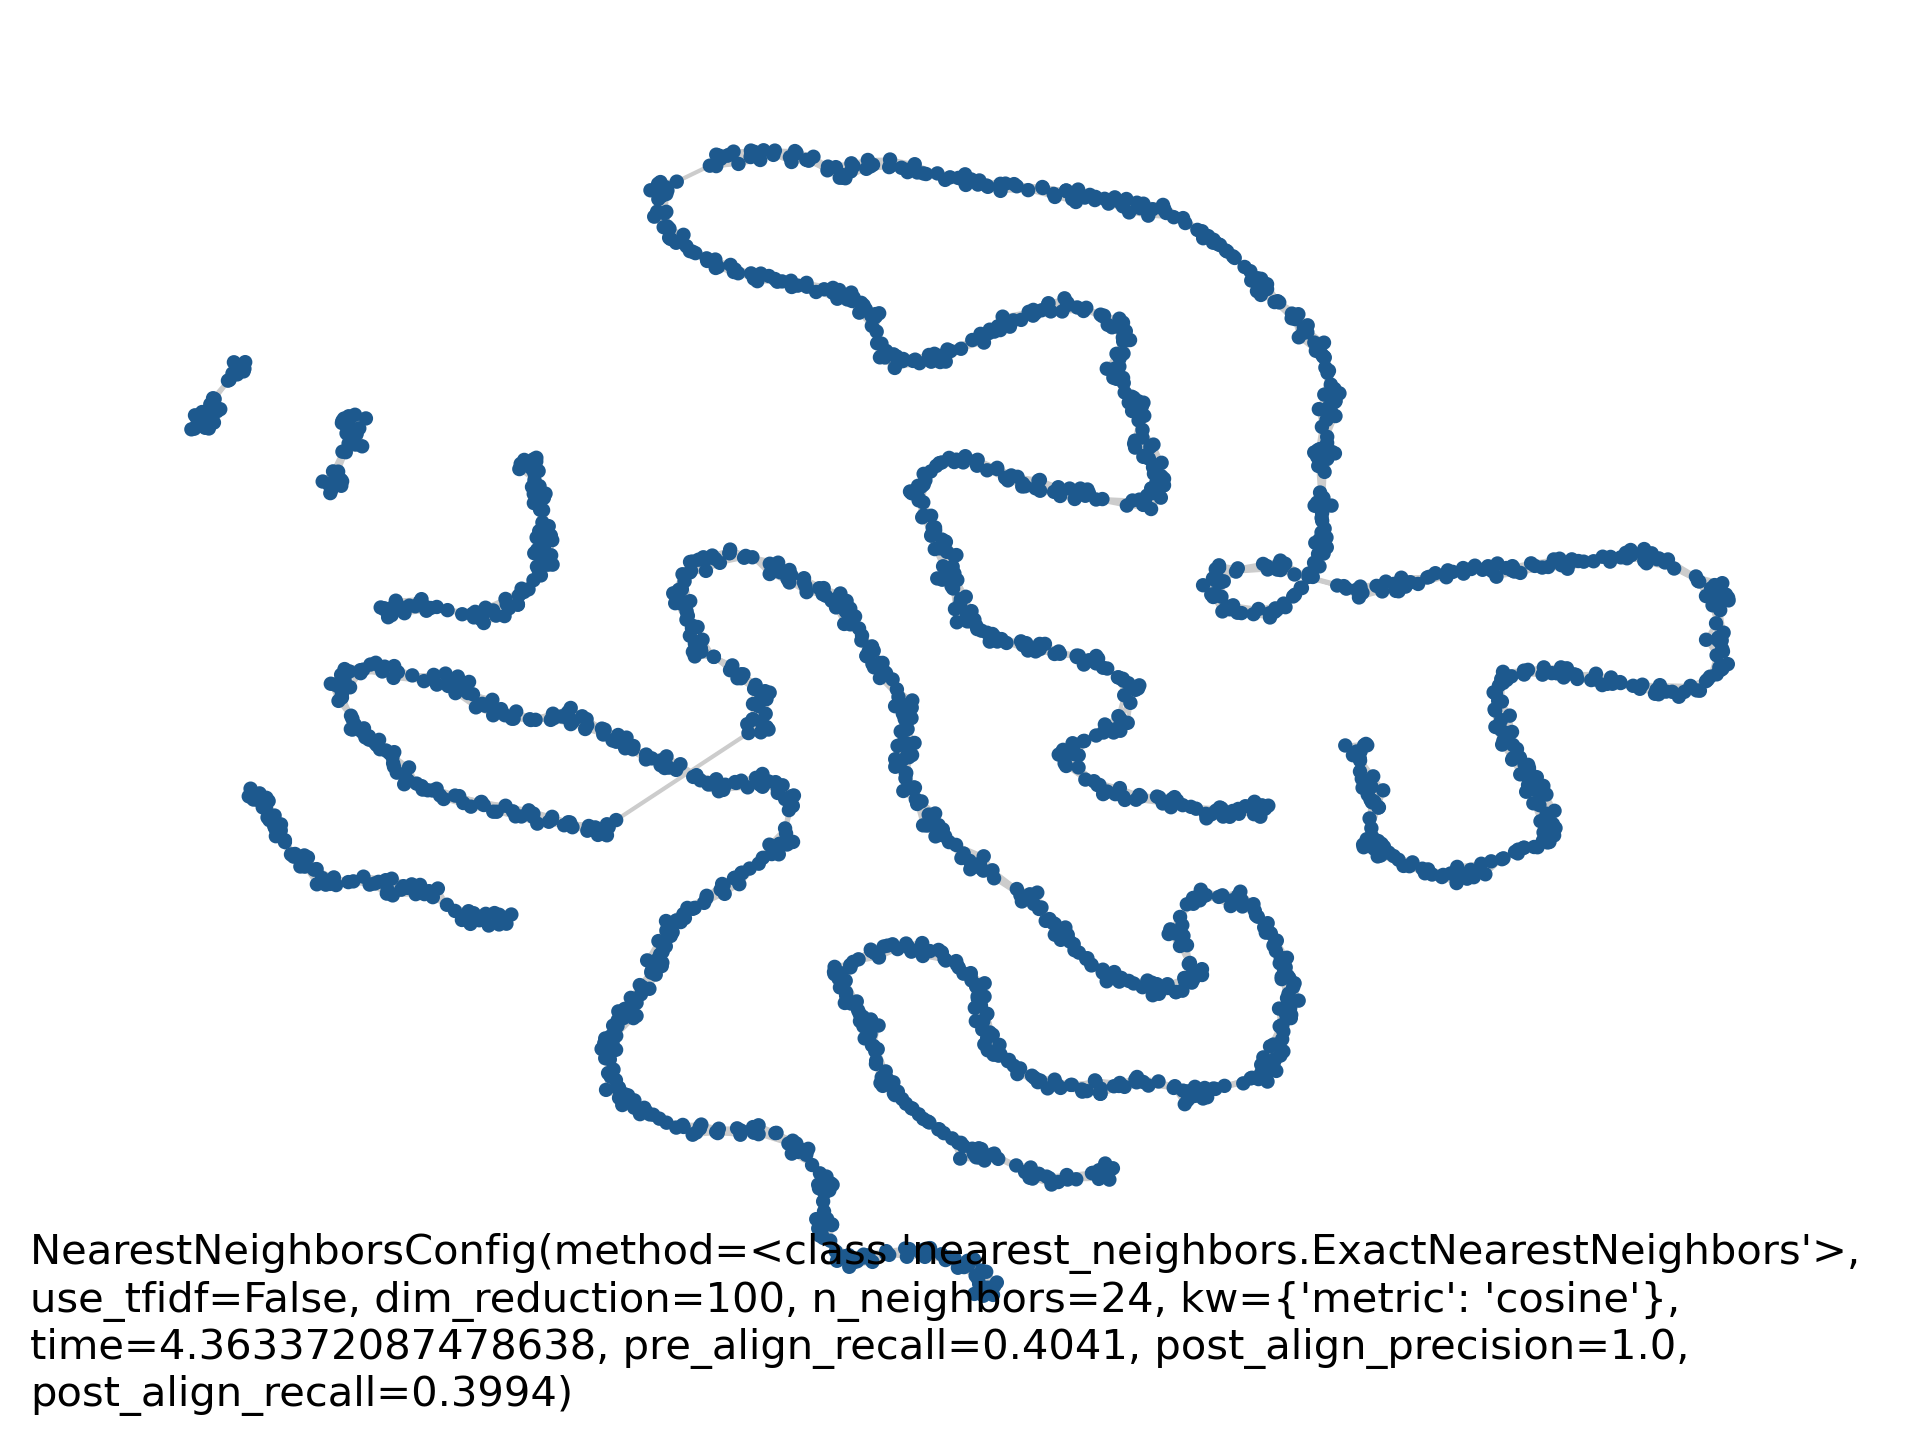

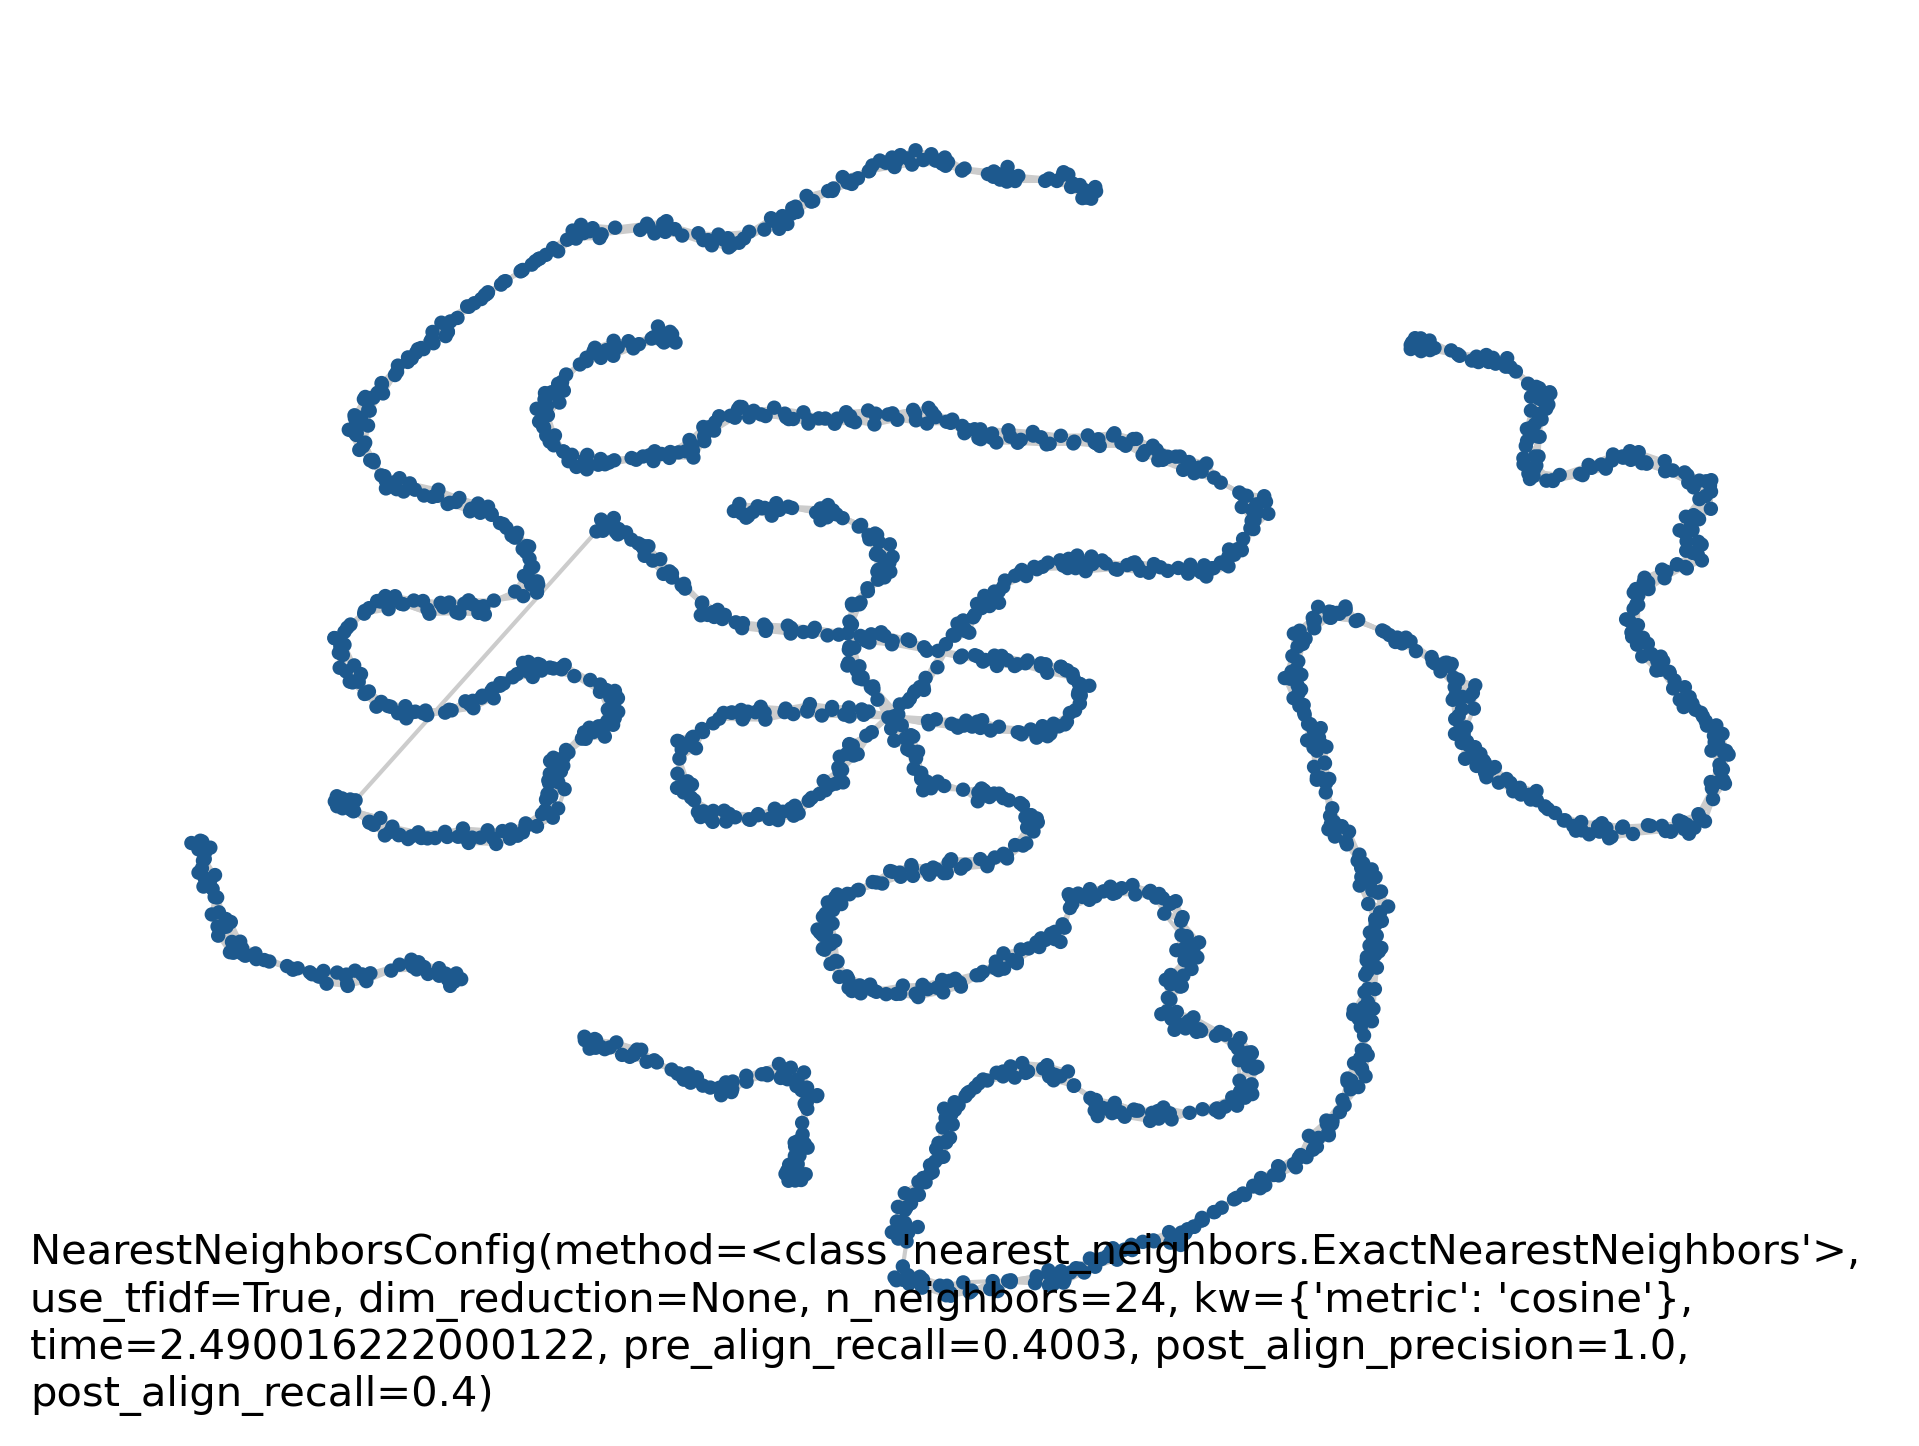

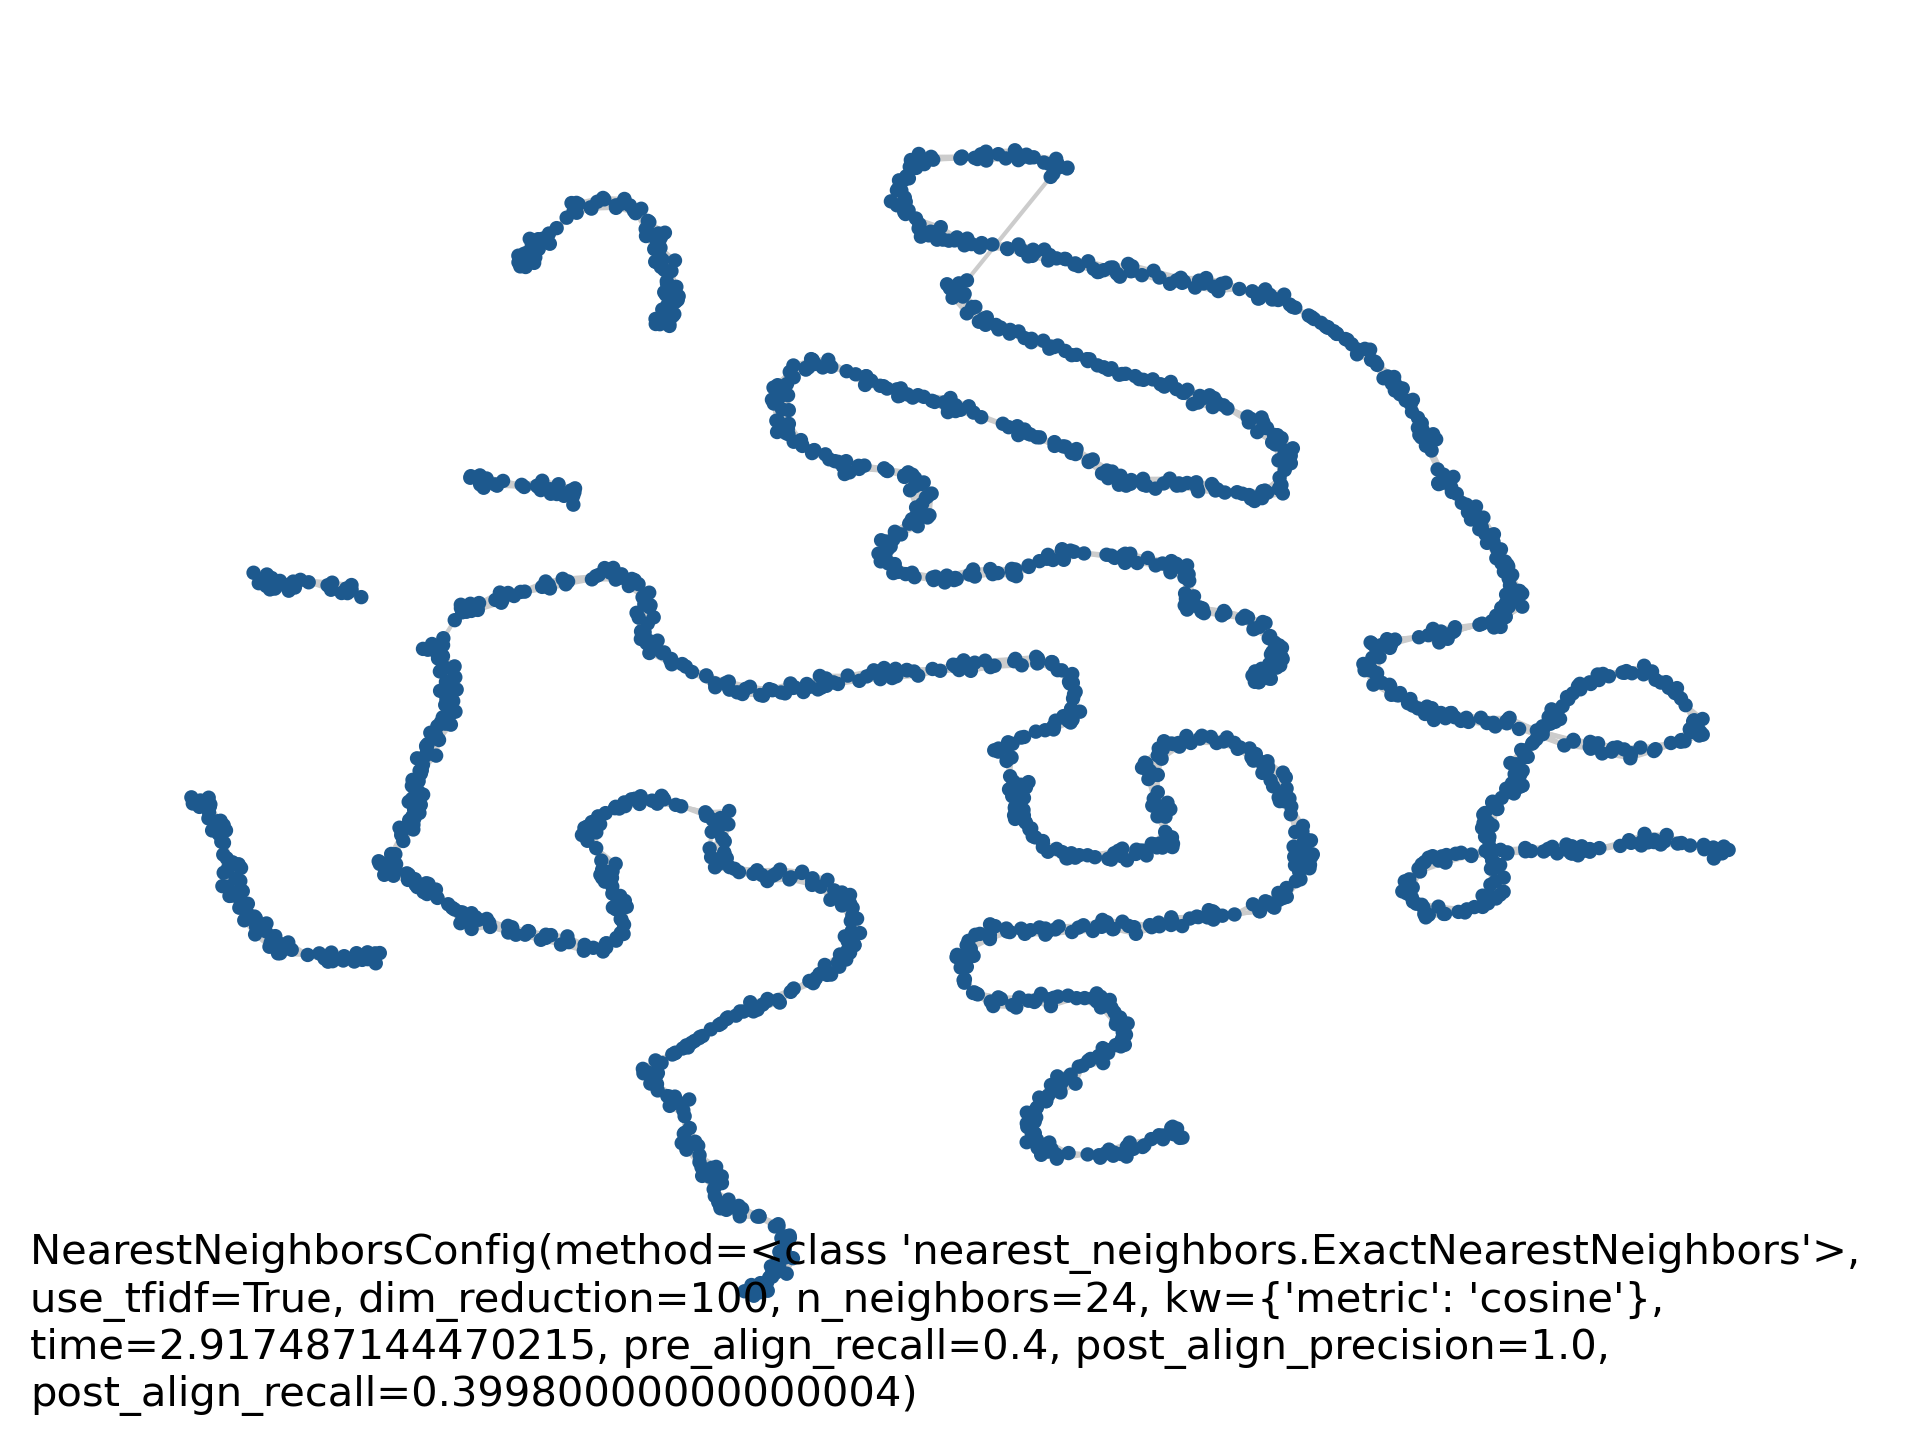

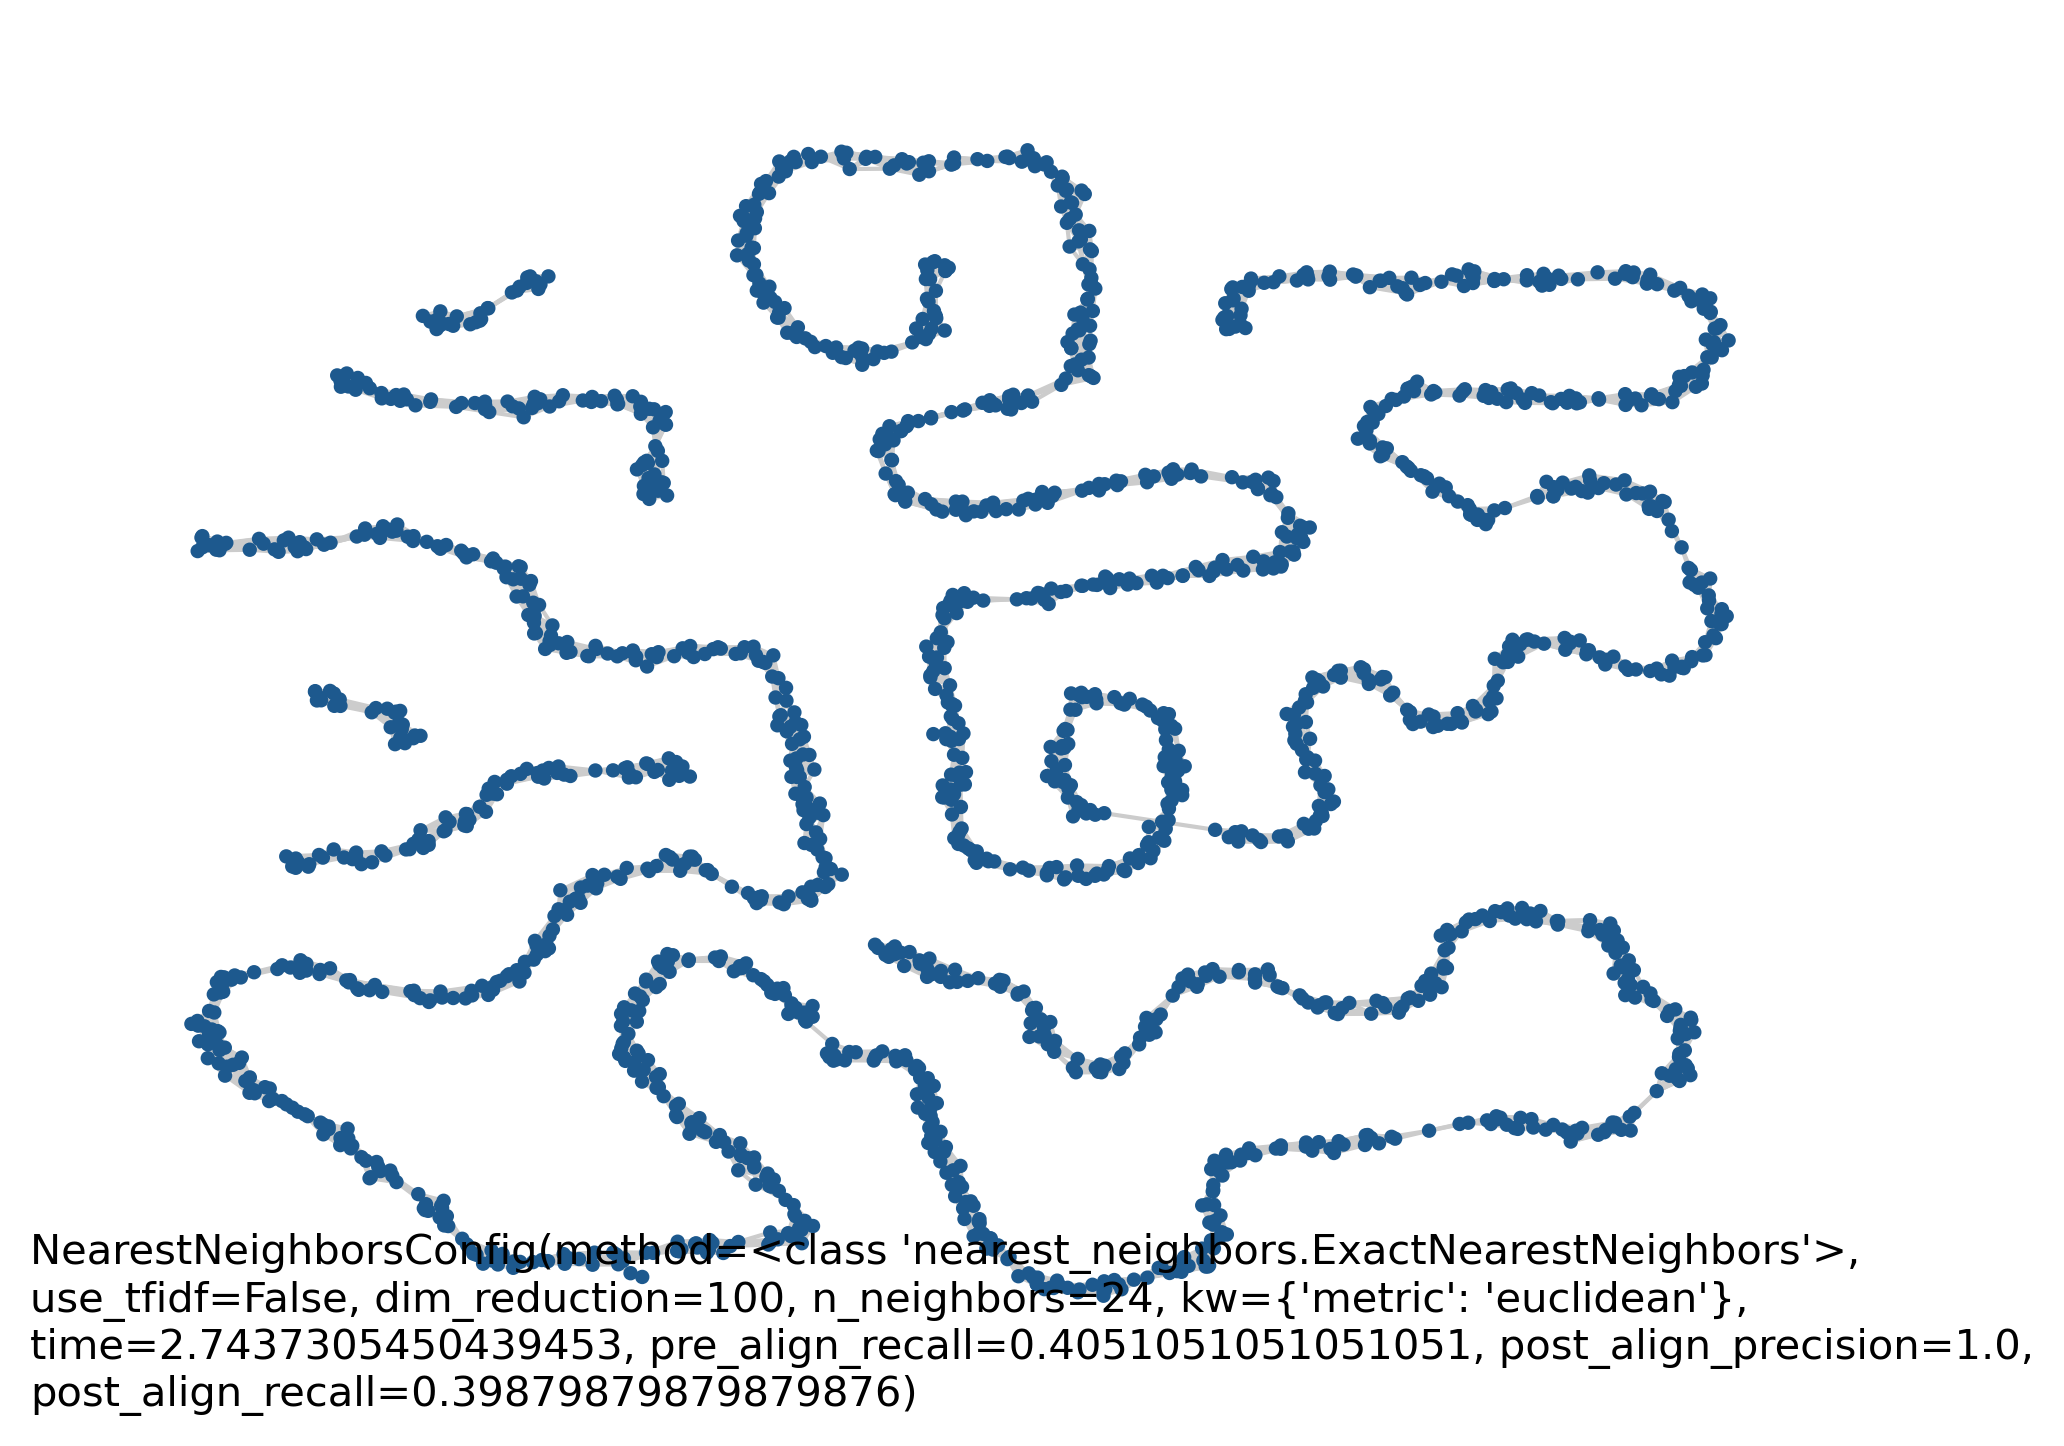

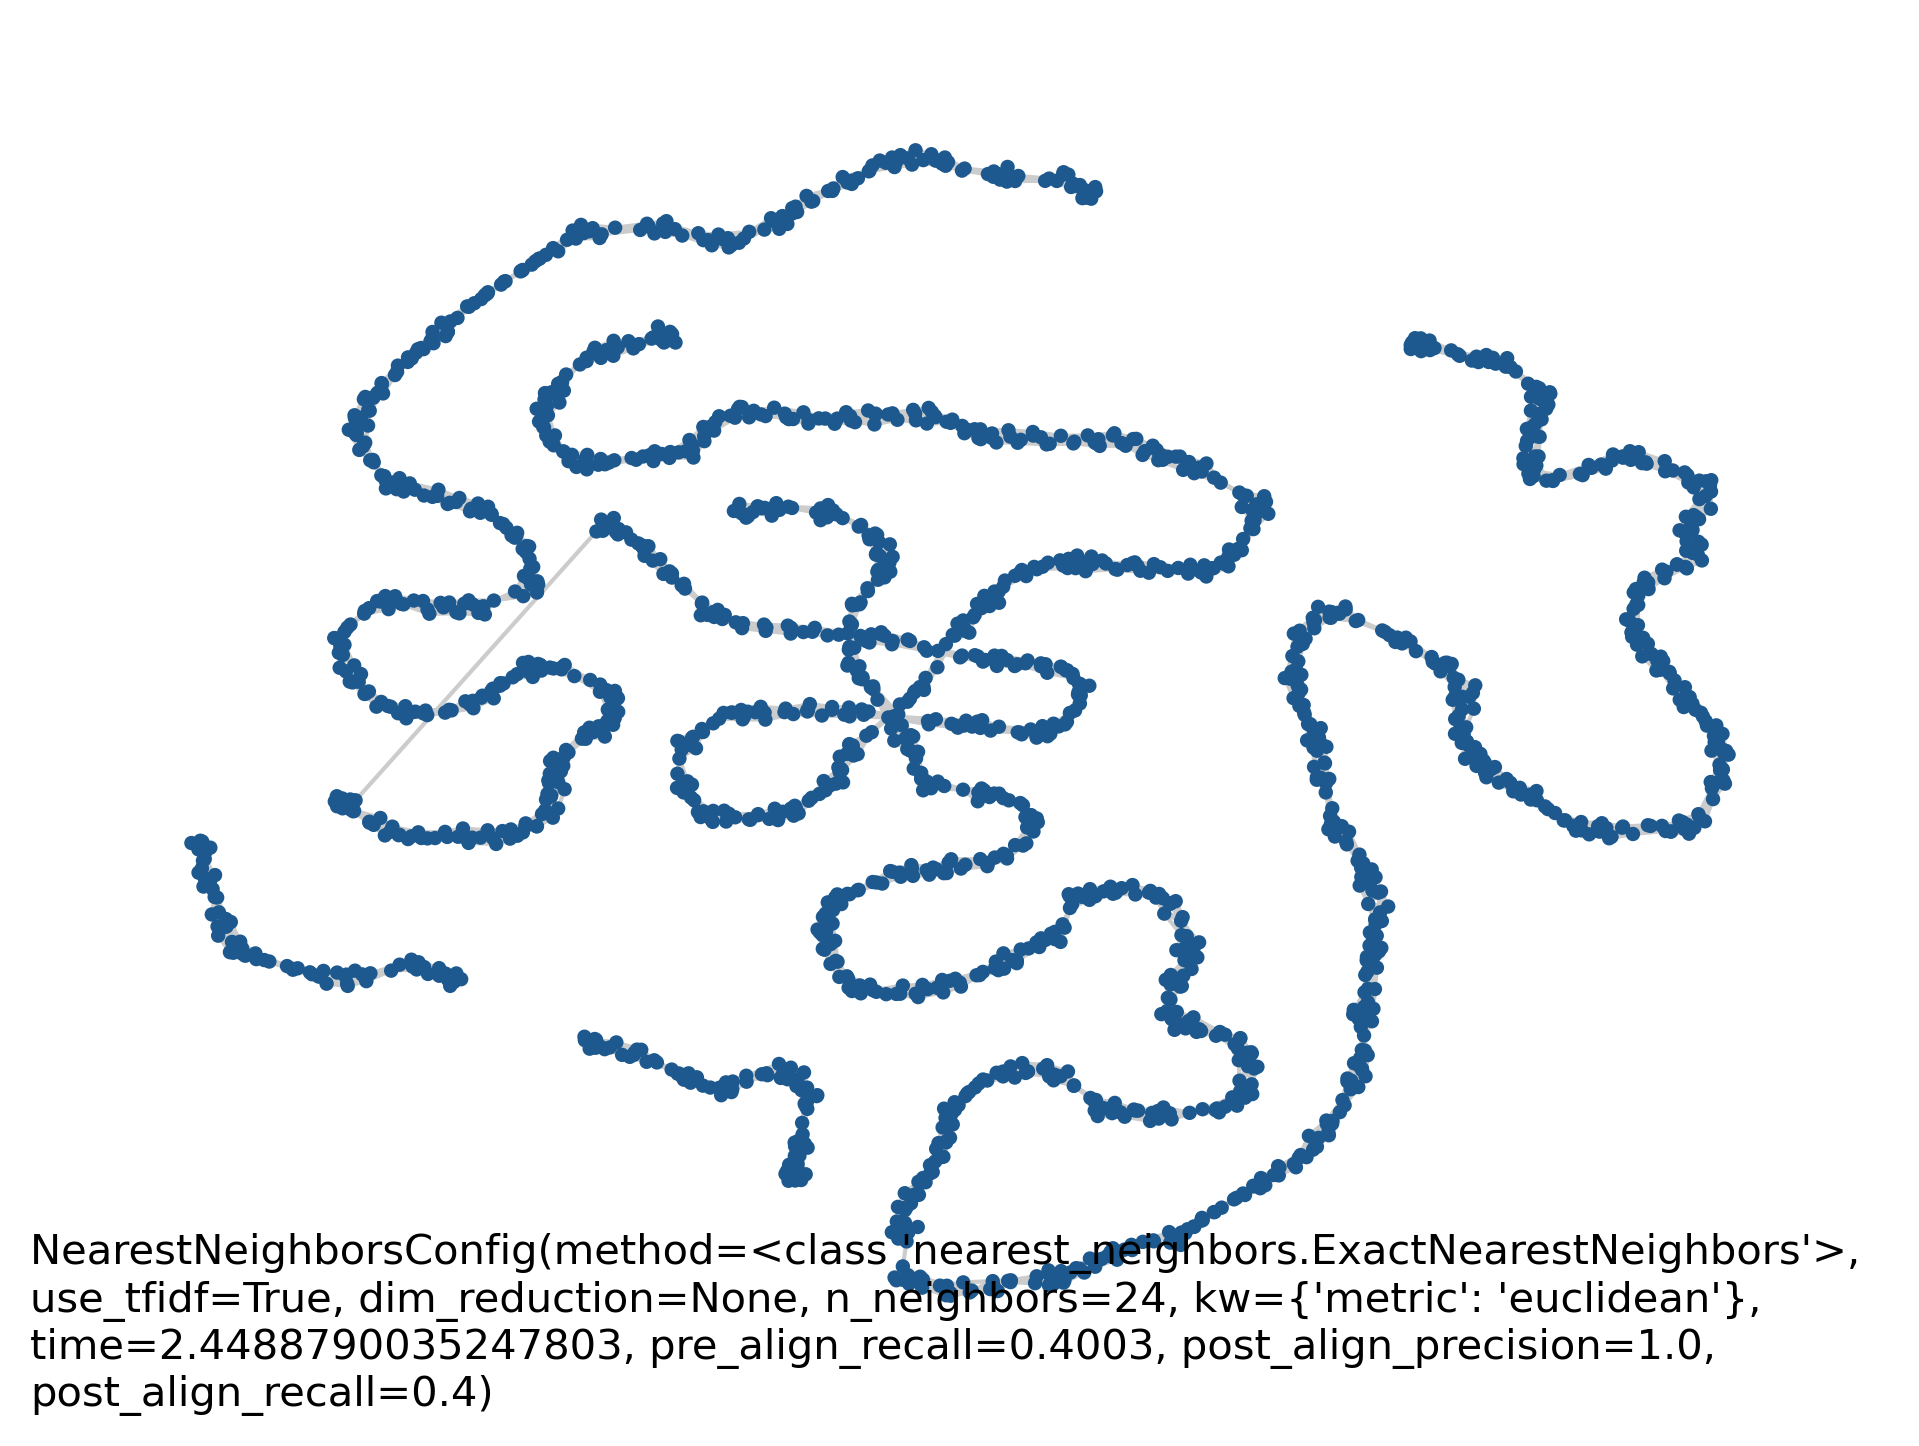

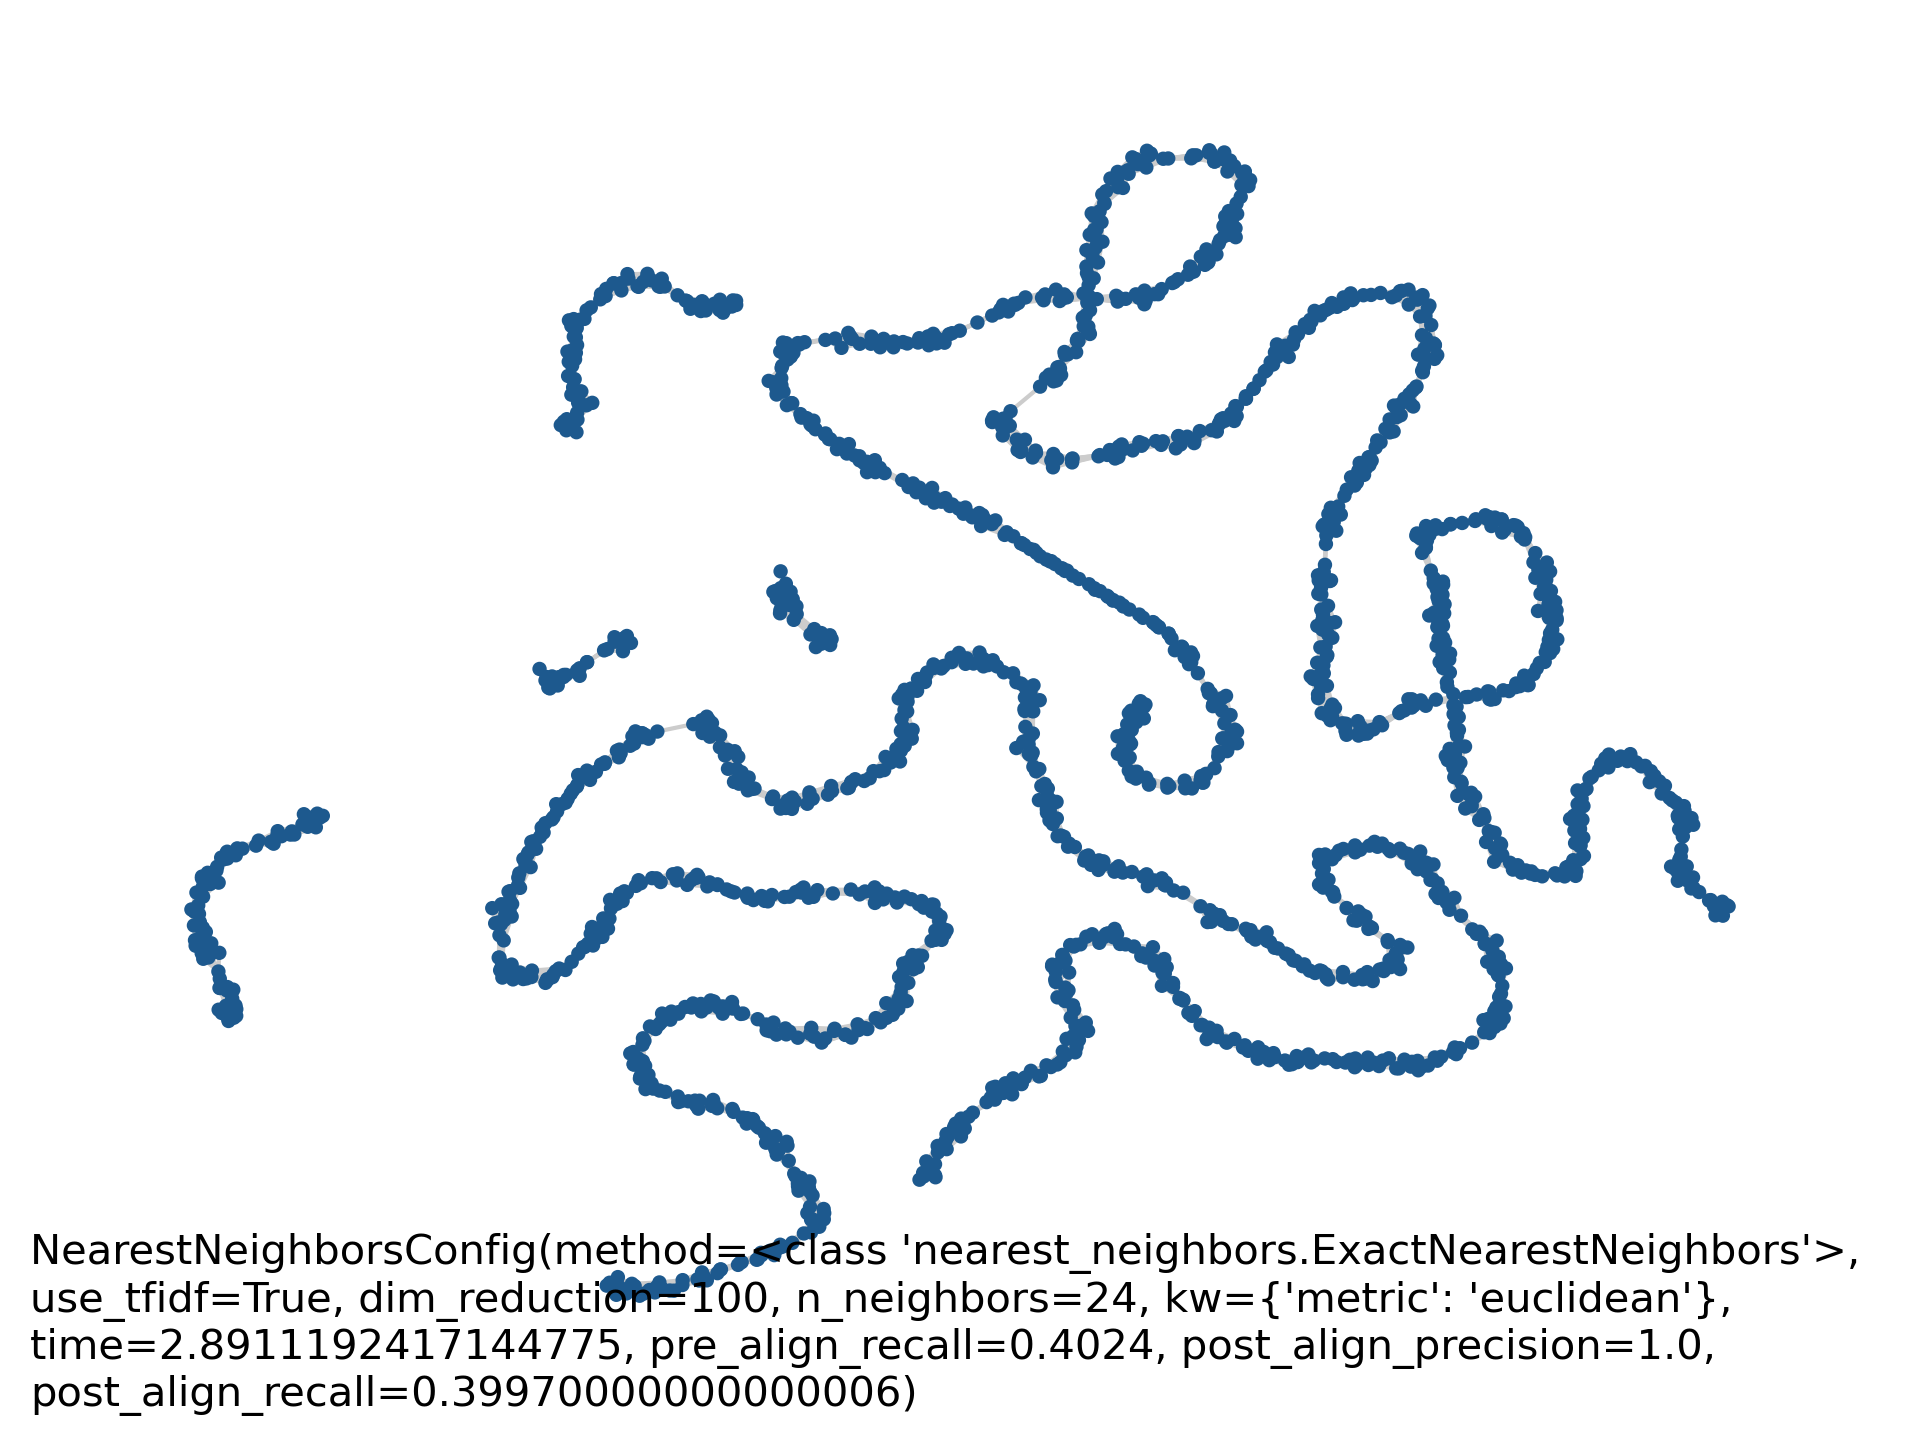

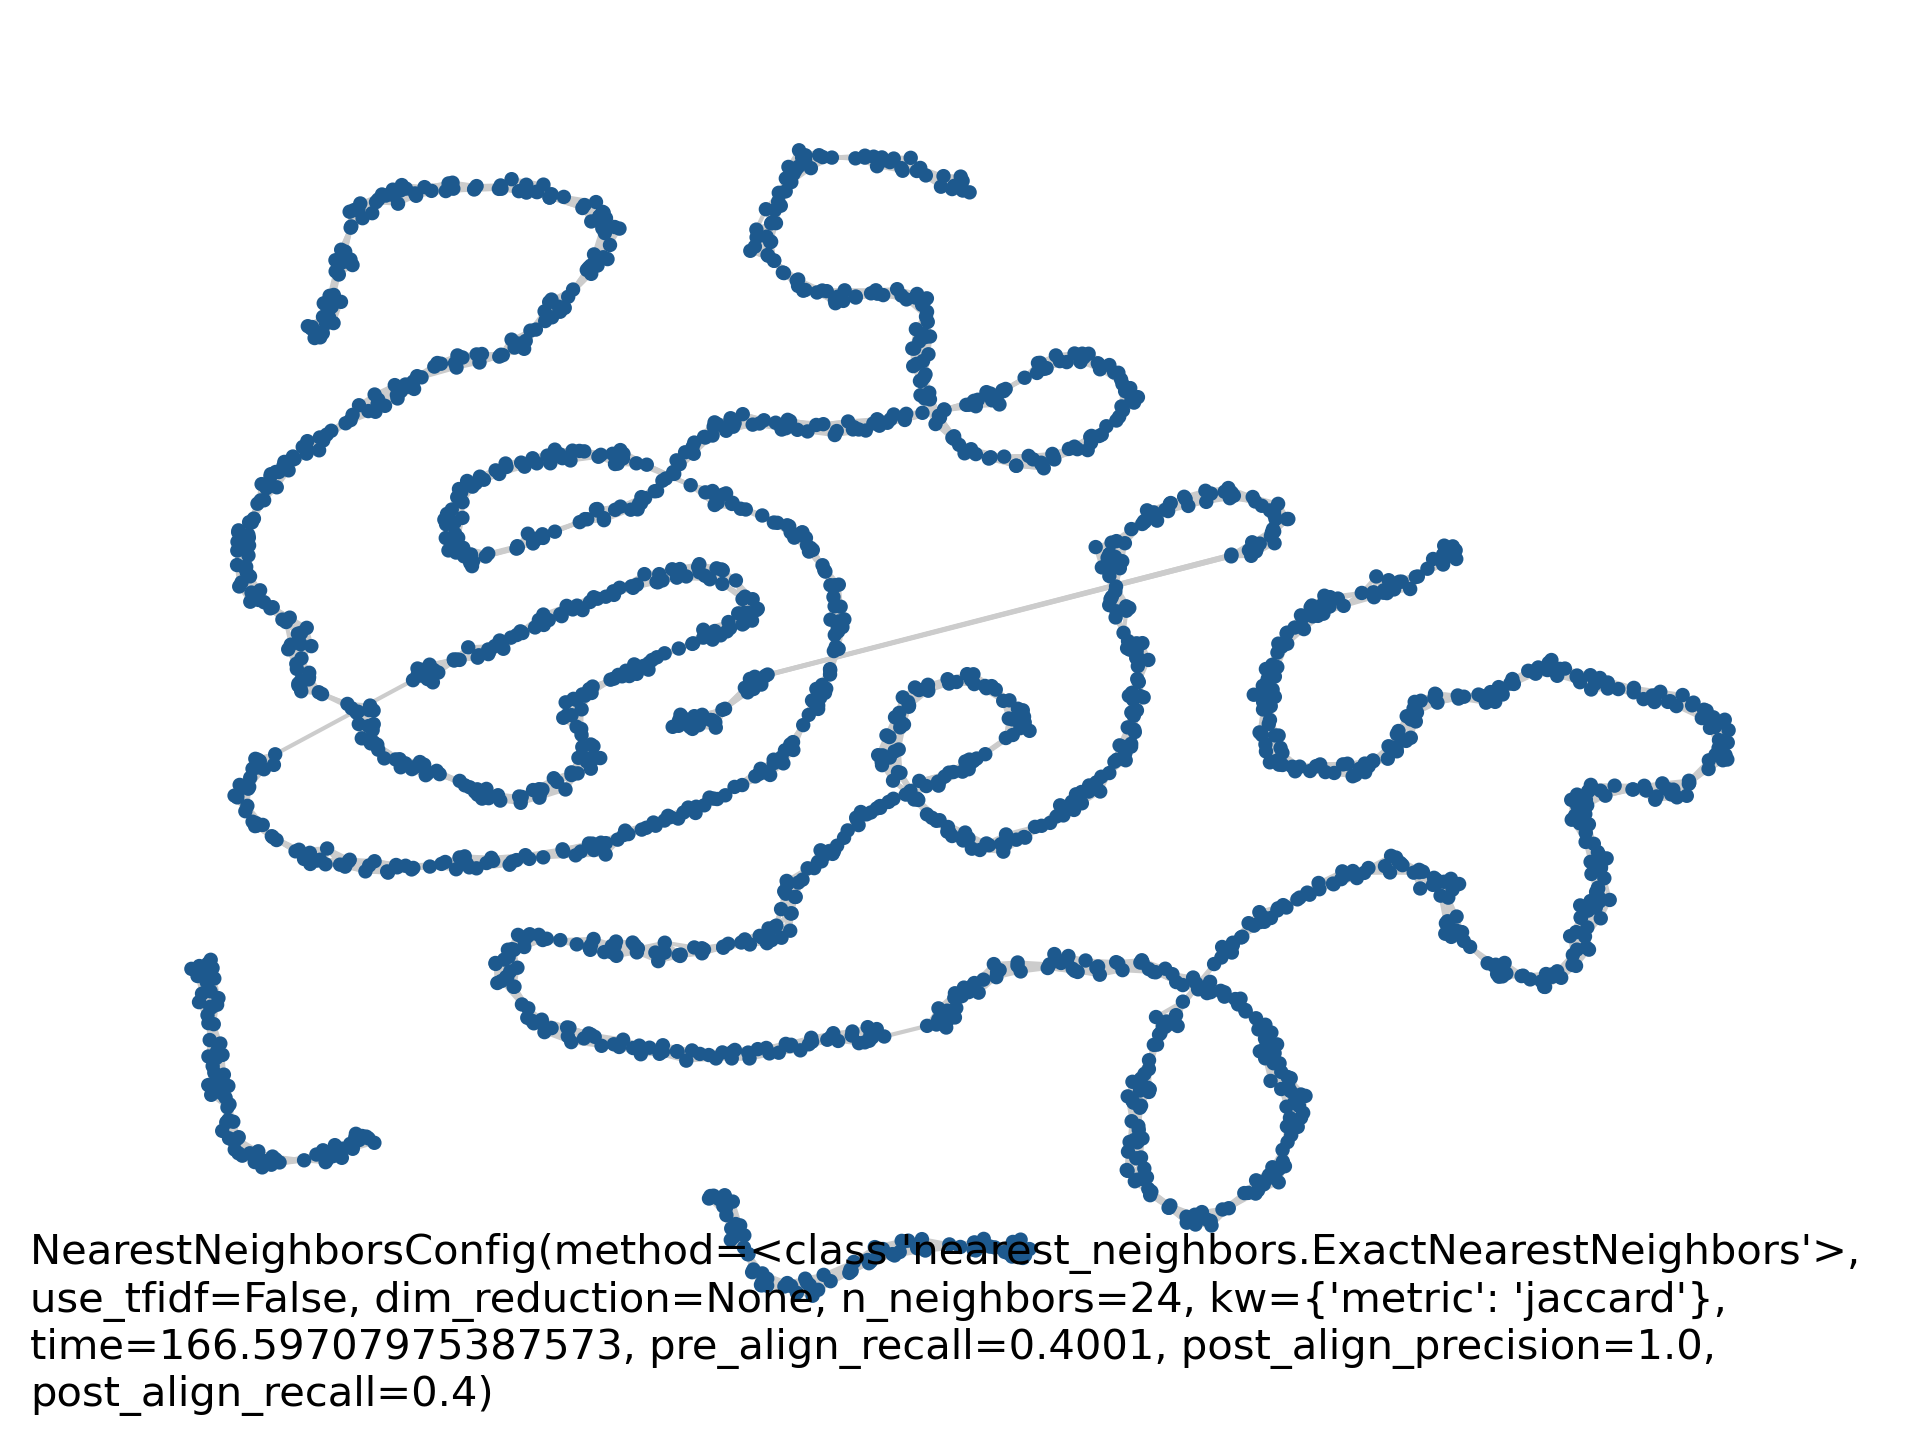

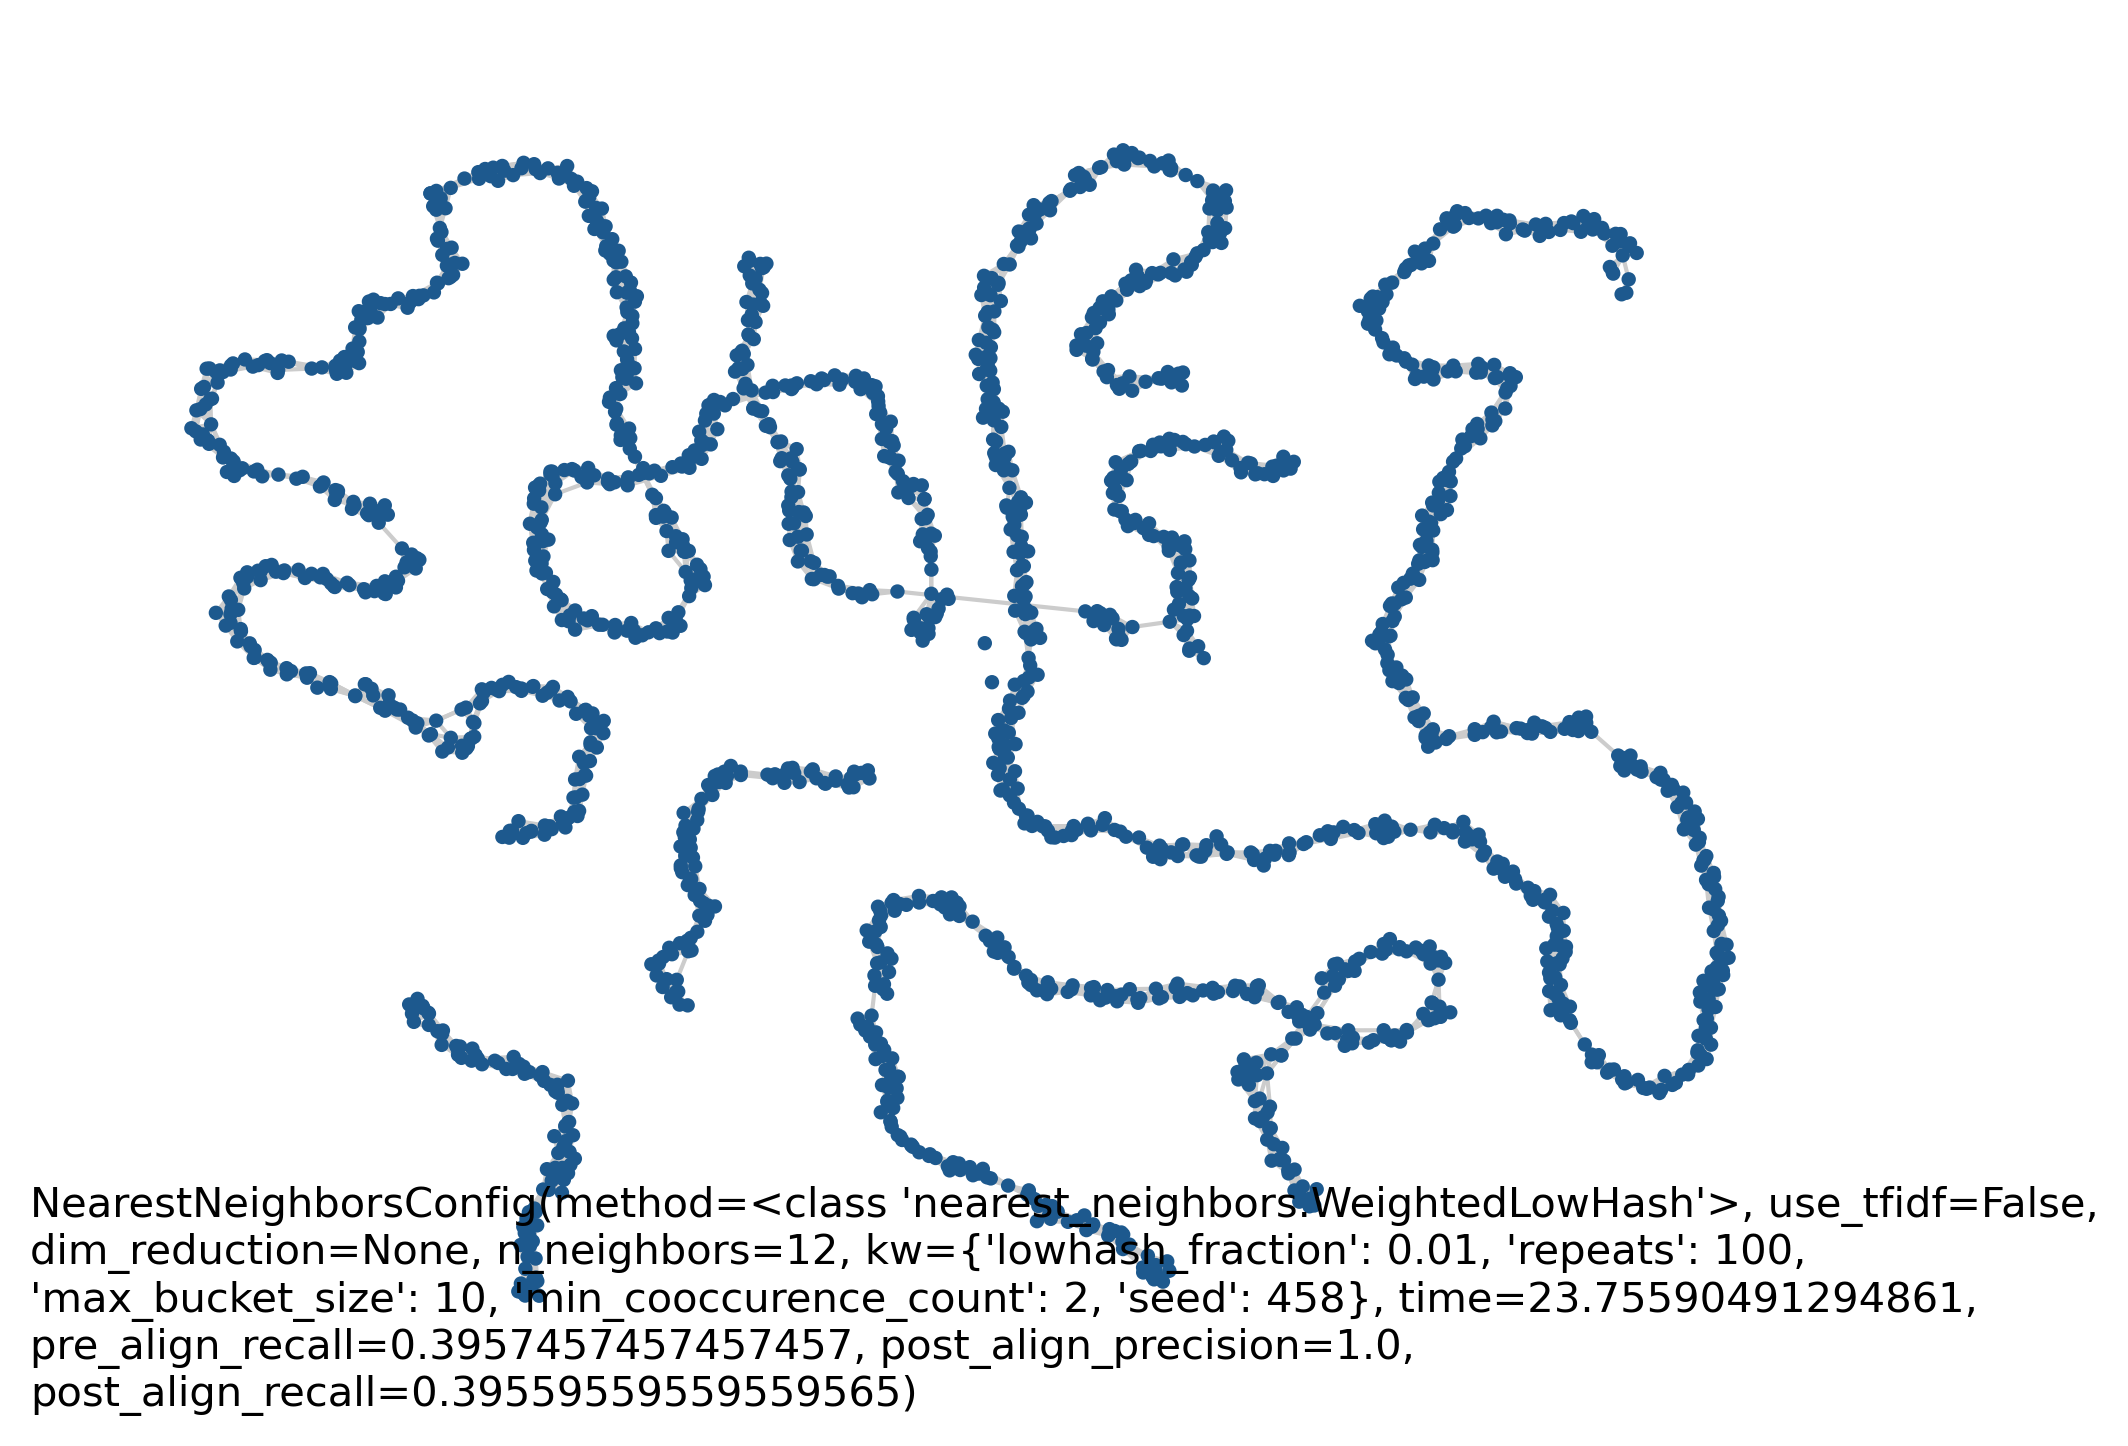

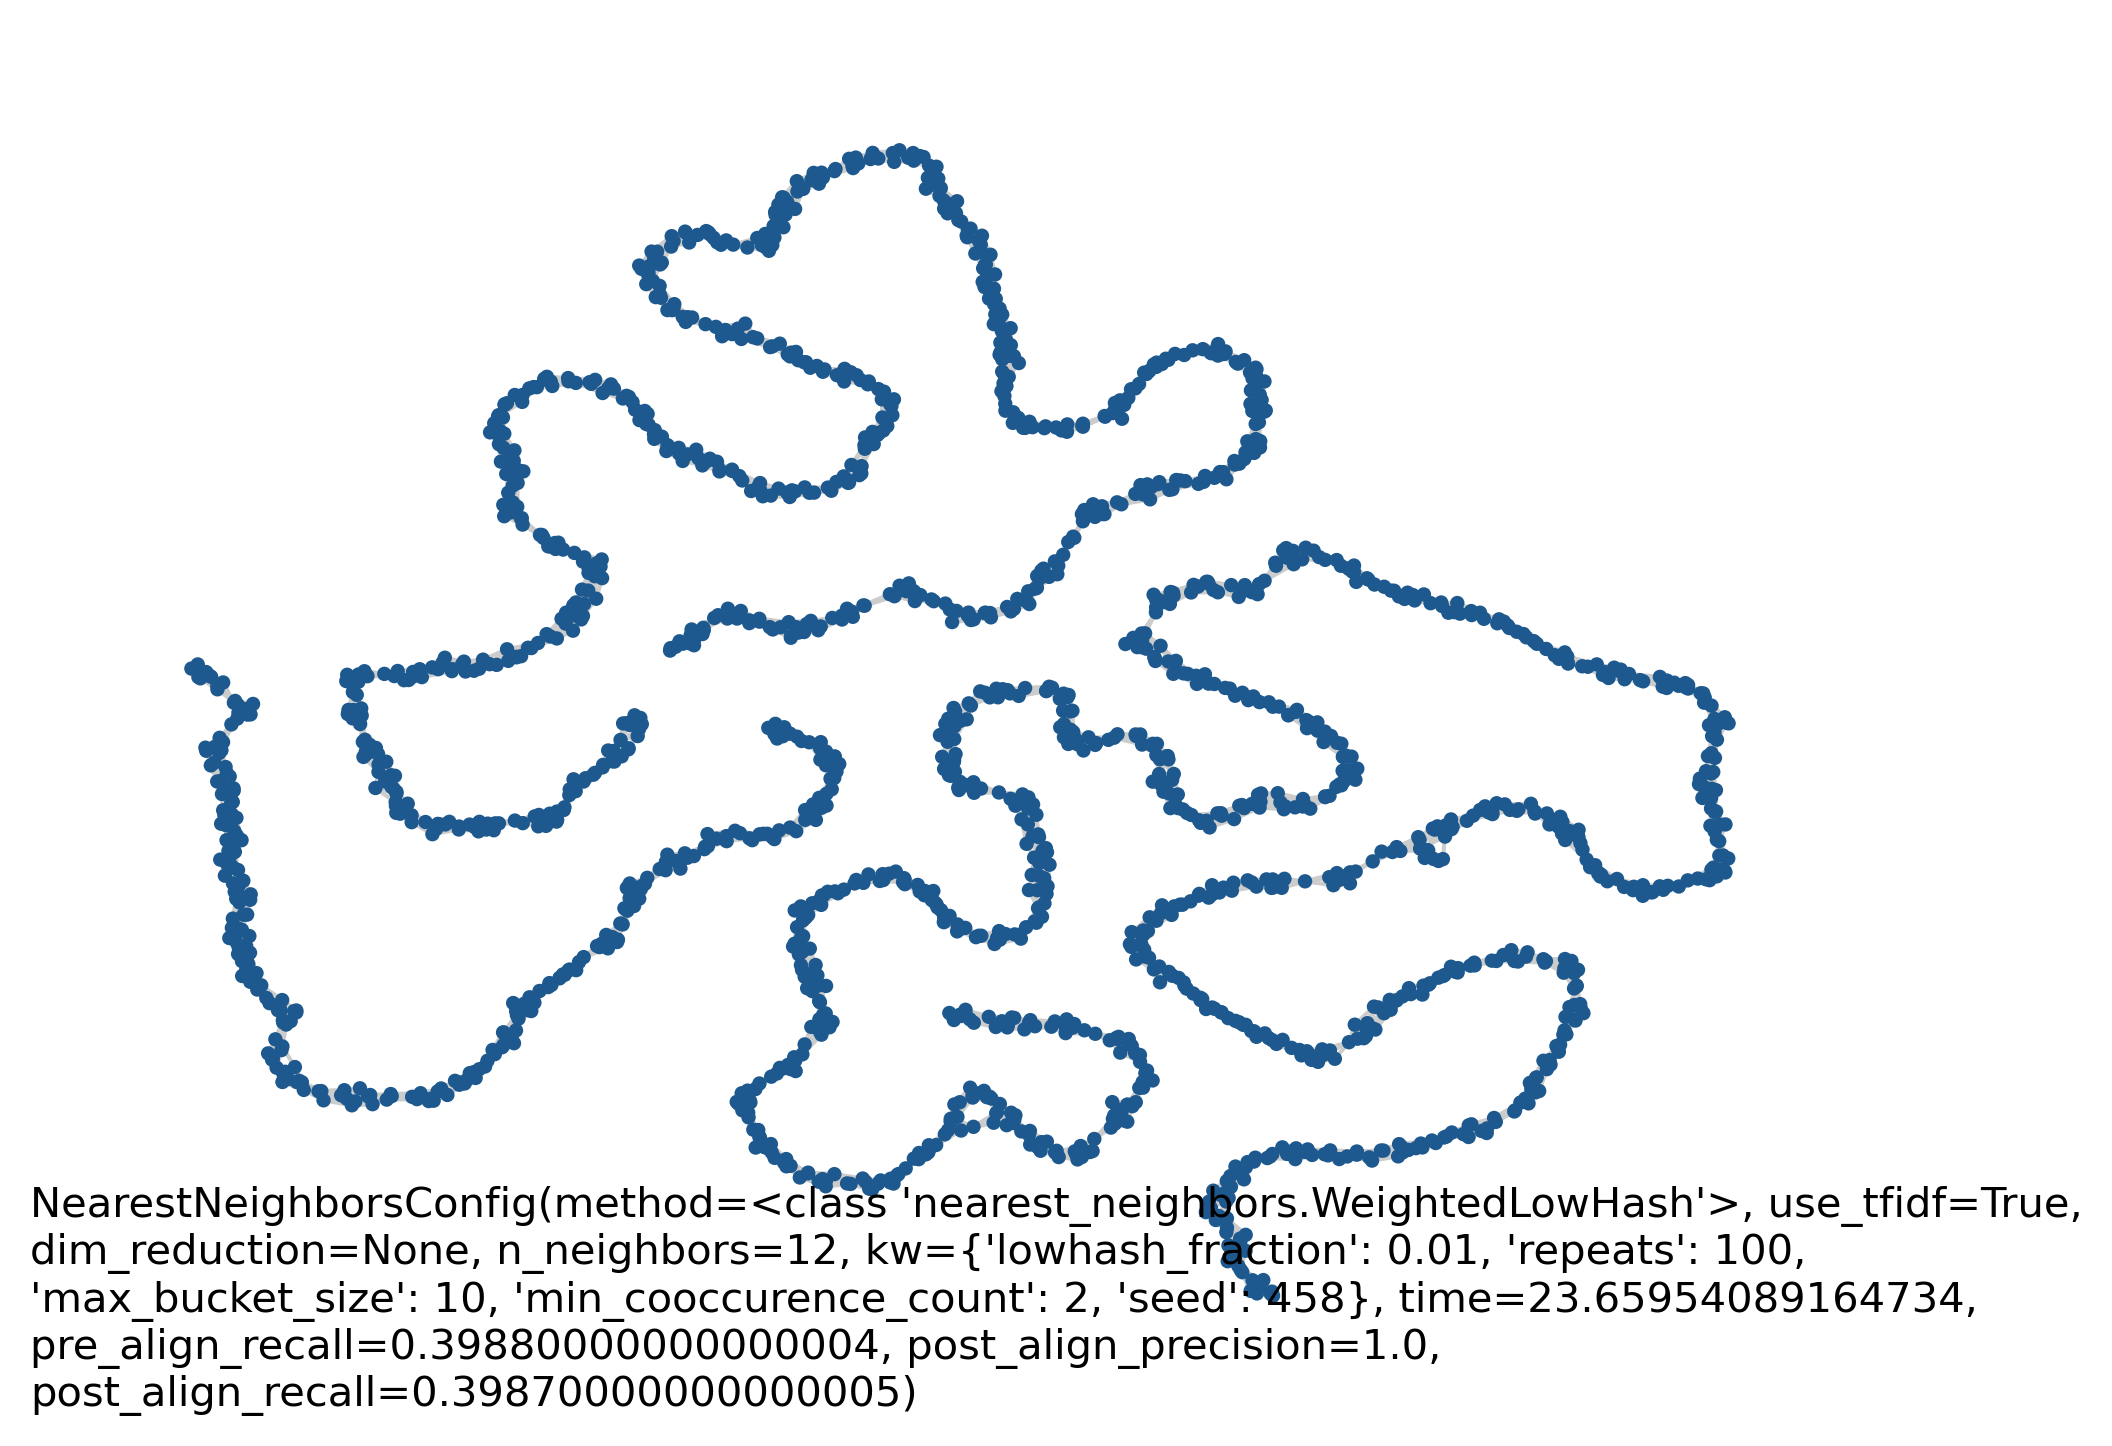

In [81]:
figures, axes = plot_configs(config_list, overlap_dict=true_overlaps, layout_method='umap', processes=16)

In [281]:
np.array(marker_matrix)

array(<2176x288628 sparse matrix of type '<class 'numpy.uint16'>'
	with 2940384 stored elements in Compressed Sparse Row format>,
      dtype=object)

In [282]:
marker_matrix

<2176x288628 sparse matrix of type '<class 'numpy.uint16'>'
	with 2940384 stored elements in Compressed Sparse Row format>

In [284]:
marker_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [157]:
lowhash_buckets = WeightedLowHash(marker_matrix[:, :10000])._pcws_low_hash(lowhash_fraction=0.01, repeats=2)

0 1000 2000 

In [159]:
lowhash_buckets.shape

(20000, 2176)

In [160]:
row_sums = lowhash_buckets.sum(axis=1).A1  # type: ignore
matrix = lowhash_buckets[
    (row_sums >= 2) & (row_sums <= 10), :
].astype(np.uint8)
cooccurrence_matrix = matrix.T.dot(matrix)

In [161]:
cooccurrence_matrix.shape

(2176, 2176)

In [141]:
%debug

> /home/ecs-user/workspace/Alder/sandbox/nearest_neighbors/nearest_neighbors.py(208)<listcomp>()
    206         k1 = read_ids[i1]
    207         row = [i2 for i2 in row if i2 != i1 and i2 >= 0]
--> 208         candidates += [(k1, read_ids[i2]) for i2 in row[:n_neighbors]]
    209 
    210     candidates += [(k2, k1) for k1, k2 in candidates]



ipdb>  i2


10222


ipdb>  len(read_ids)


2176


ipdb>  exit


In [92]:
tfidf_marker_matrix = TfidfTransformer(use_idf=True, smooth_idf=True).fit_transform(marker_matrix)

In [110]:
nbr_matrix = ExactNearestNeighbors(tfidf_marker_matrix).get_neighbors(n_neighbors=20, metric='cosine')

In [76]:
nbr_matrix = WeightedLowHash(marker_matrix).get_neighbors(
    n_neighbors=20,
    lowhash_fraction=0.01,
    repeats=100,
    max_bucket_size=10,
    min_bucket_size=2,
    min_cooccurence_count=2,
    seed=14848,
)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 

In [111]:
candidates = get_overlap_candidates(nbr_matrix, regional_read_ids, n_neighbors=12)
len(candidates)

34296

In [112]:
nbr_matrix.max()

2175

## Pre-alignment evaluation

In [114]:
import graph
reload(graph)
from graph import (
    get_pre_alignment_read_graph,
    get_post_alignment_read_graph
)
import truth
reload(truth)
from truth import load_alignment_intervals, get_overlaps, get_nearest_neighbors, get_read_graph_statistics

In [116]:
pickle_file = "data/pickle/overlap_dict.pickle.gz"

with gzip.open(pickle_file, "rb") as f:
    overlap_dict = pickle.load(f)

In [117]:
pre_alignment_graph = get_pre_alignment_read_graph(candidates)
result = get_read_graph_statistics(pre_alignment_graph, overlap_dict, n_neighbors=12)
result['precision'], result['recall']

(0.9184161418241195, 0.537530637254902)

## Pairwise alignment

In [ ]:
# Weighted semiglobal alignment algorithm
import weighted_alignment

reload(weighted_alignment)
from weighted_alignment import (
    Seq,
    WeightedSemiglobalAligner,
    cWeightedSemiglobalAligner,
    BandedWeightedAligner,
    TwoStepSemiglobalAligner,
    HeuristicAligner,
    plot_alignment,
    plot_dp_matrix,
    test_alignment,
    pairwise_sample,
    get_intersection_fraction,
    run_multiprocess_alignment,
)
test_alignment()

In [ ]:
pickle_file = "data/pickle/alignment_dict.pickle.gz"
use_pickle = True

if os.path.isfile(pickle_file) and use_pickle:
    with gzip.open(pickle_file, "rb") as f:
        alignment_dict = pickle.load(f)
else:
    alignment_dict = {}


new_candidates = set(candidates) - set(alignment_dict)
new_candidates = list(new_candidates)

if new_candidates:
    new_alignment_dict = run_multiprocess_alignment(
        new_candidates,
        read_markers,
        marker_weights,
        aligner=cWeightedSemiglobalAligner,
        align_kw=dict(max_cells=int(2e9)),
        traceback=False,
        processes=30,
        batch_size=200,
        min_free_memory_gb=48,
        max_total_wait_seconds=300,
    )
    alignment_dict.update(new_alignment_dict)
    if use_pickle:
        with gzip.open(pickle_file, "wb") as f:
            pickle.dump(alignment_dict, f)

## Read graph

In [235]:
node_neighbors = collections.defaultdict(dict)
keys = list(read_markers)
for k1, k2 in regional_candidates:
    score = alignment_dict[(k1, k2)].score
    node_neighbors[k1][k2] = score
    node_neighbors[k2][k1] = score

In [264]:
nearest_neighbor_count = 6
check_alignment = True


false_neighbors = set()

read_graph = nx.Graph()
g = read_graph

for node, neighbors in node_neighbors.items():
    g.add_node(node)
    nbr_scores = list(sorted(neighbors.values(), reverse=True))
    if check_alignment:
        nbr_scores = [x for x in nbr_scores if x > 0]
    if not nbr_scores:
        continue
    min_score = nbr_scores[:nearest_neighbor_count][-1]
    nearest_neighbors = {x: score for x, score in neighbors.items() if score >= min_score}

    for nbr_node, score in nearest_neighbors.items():
        if nbr_node == get_sibling_id(node):
            # Skip self edges
            continue
        if (node, nbr_node) in true_overlaps:
            identity = True
        else:
            identity = False
            false_neighbors.add((node, nbr_node))
        g.add_edge(node, nbr_node, identity=identity, alignment_score=score)
len(g.nodes), len(g.edges)

(2176, 8534)

## Evaluation

In [105]:
import truth
reload(truth)
from truth import load_alignment_intervals, get_overlaps, get_nearest_neighbors, get_read_graph_statistics

In [106]:
pickle_file = "data/pickle/overlap_dict.pickle.gz"

with gzip.open(pickle_file, "rb") as f:
    overlap_dict = pickle.load(f)

In [107]:
result = get_read_graph_statistics(pre_alignment_graph, overlap_dict, n_neighbors=12)

In [108]:
result['precision']

0.9151850772369572

In [109]:
result['recall']

0.538296568627451

## Visualisation

In [253]:
import scanpy as sc
import anndata as ad

In [249]:
config = config_list[2]

In [250]:
config

NearestNeighborsConfig(method=<class 'nearest_neighbors.ExactNearestNeighbors'>, use_tfidf=False, n_neighbors=12, kw={'metric': 'euclidean'}, time=0.9114792346954346, pre_align_precision=0.8963999108337048, pre_align_recall=0.4676011029411765, post_align_precision=0.9915617128463476, post_align_recall=0.4163602941176471)

In [251]:
g = get_post_alignment_read_graph(
    config.overlap_candidates,
    alignment_dict,
    n_neighbors=6,
    require_alignment=True,
)
BLUE = (29 / 255, 89 / 255, 142 / 255, 1)
GRAY = (0.8, 0.8, 0.8, 1)
RED = (1, 0.1, 0.1, 1)
GREEN = (53 / 255, 125 / 255, 35 / 255, 1)

edge_colors = []
for edge, attr in g.edges.items():
    color = 'k'
    # if attr["identity"] is True:
    #     color = GRAY
    # else:
    #     color = RED
    edge_colors.append(color)


node_colors = [BLUE if x >= 0 else GREEN for x in g.nodes]
pos = nx.nx_agraph.graphviz_layout(g, prog='neato', args='-Gsize="8,6" -Gstart=43')
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx(
    g,
    ax=ax,
    pos=pos,
    with_labels=False,
    node_size=6,
    edge_color=edge_colors,
    node_color=node_colors,
)

In [252]:
BLUE = (29 / 255, 89 / 255, 142 / 255, 1)
GRAY = (0.8, 0.8, 0.8, 1)
RED = (1, 0.1, 0.1, 1)
GREEN = (53 / 255, 125 / 255, 35 / 255, 1)

edge_colors = []
for edge, attr in g.edges.items():
    color = 'k'
    # if attr["identity"] is True:
    #     color = GRAY
    # else:
    #     color = RED
    edge_colors.append(color)


node_colors = [BLUE if x >= 0 else GREEN for x in g.nodes]

In [253]:
pos = nx.nx_agraph.graphviz_layout(g, prog='neato', args='-Gsize="8,6" -Gstart=43')

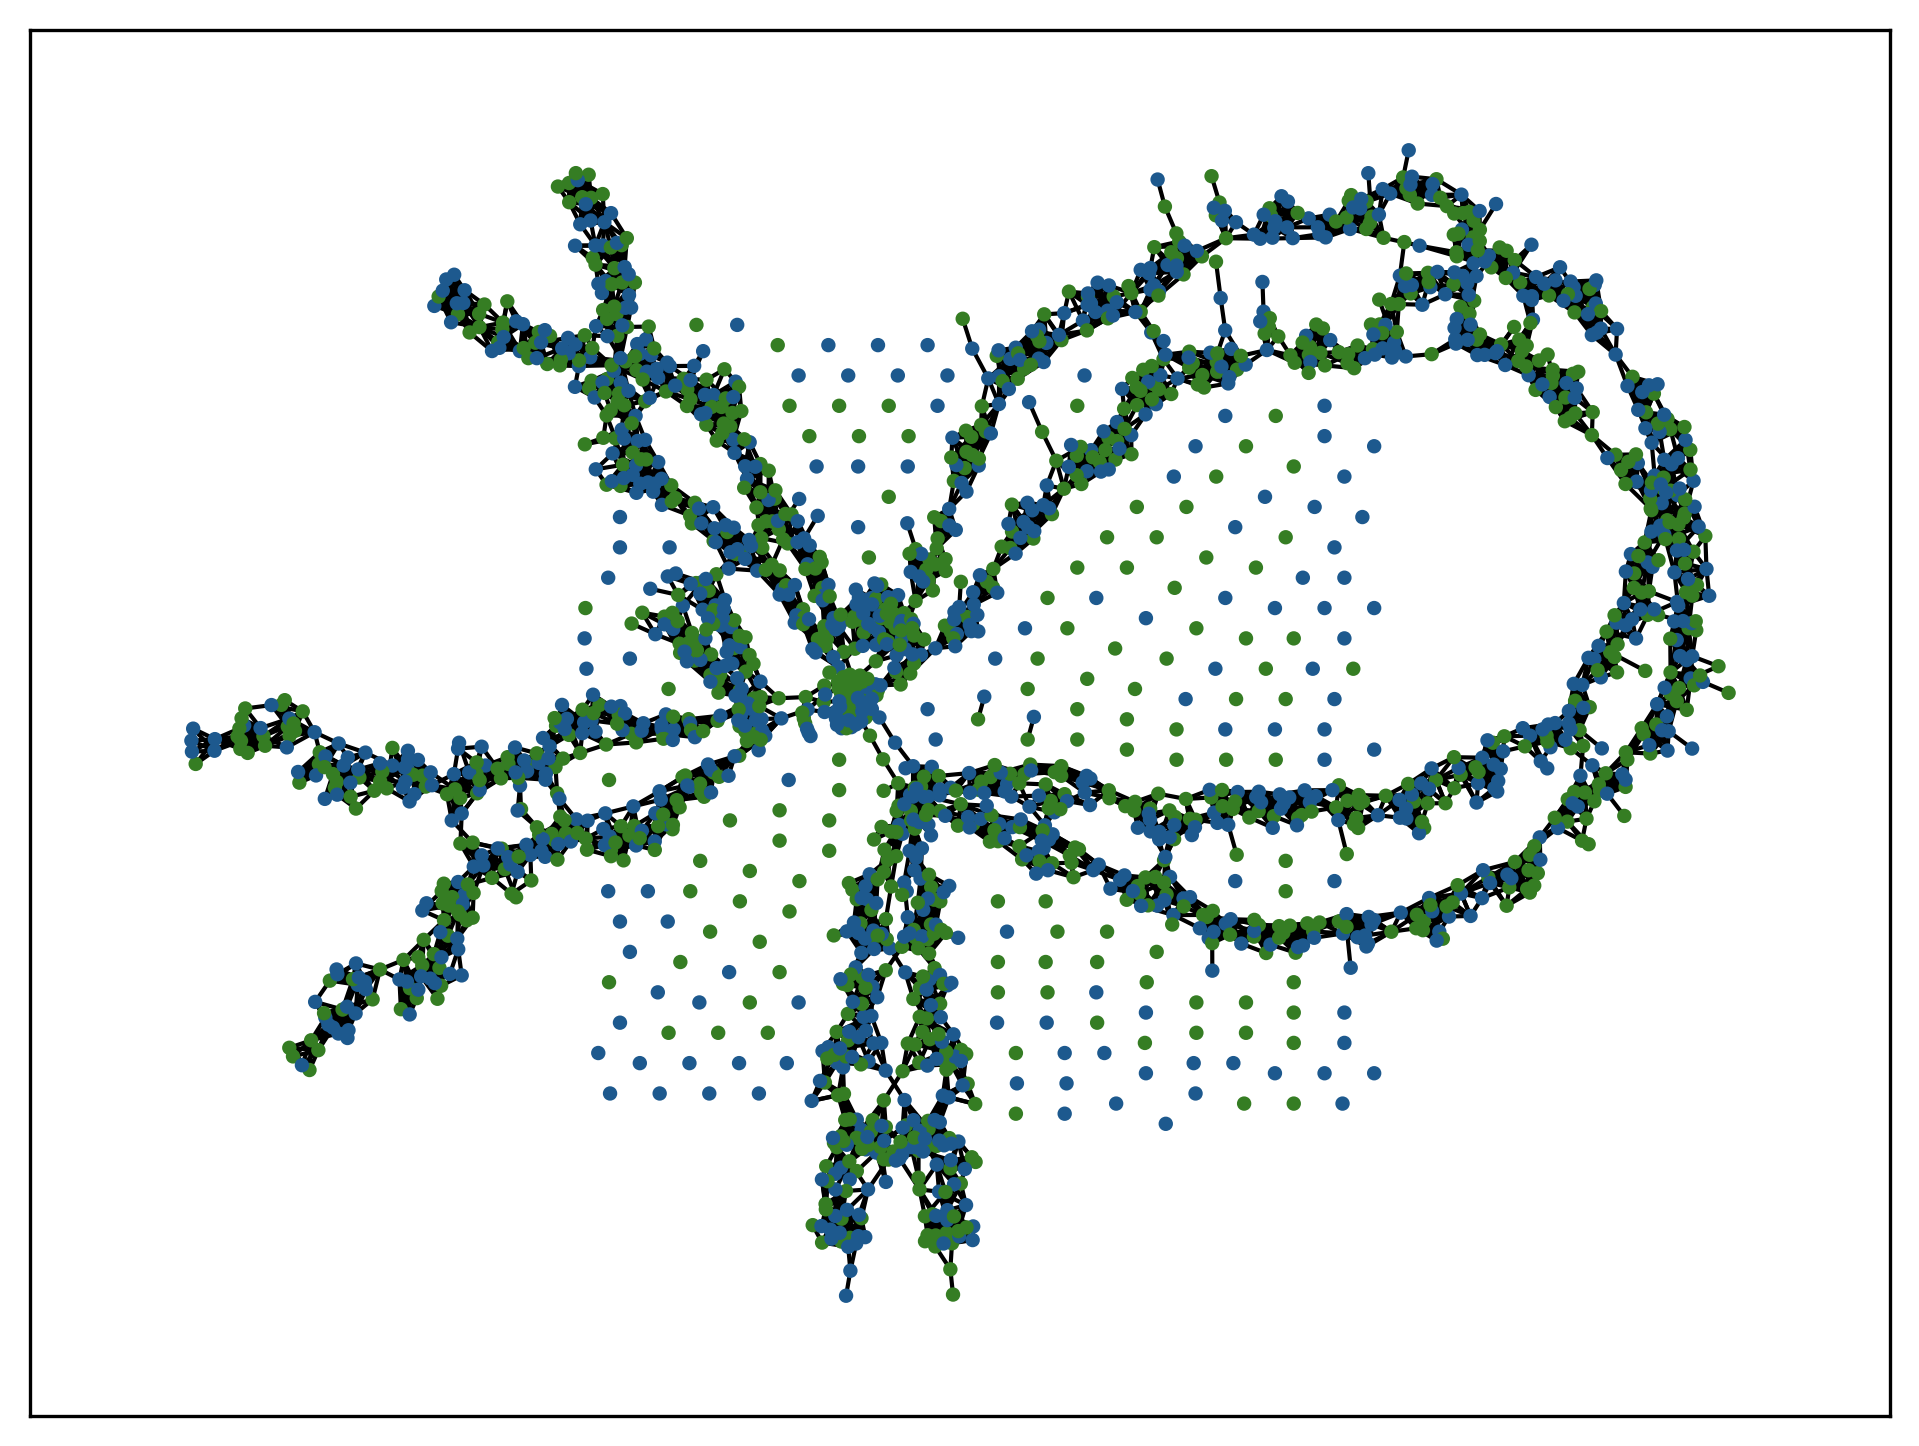

In [254]:
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx(
    g,
    ax=ax,
    pos=pos,
    with_labels=False,
    node_size=6,
    edge_color=edge_colors,
    node_color=node_colors,
)

In [59]:
from umap.umap_ import nearest_neighbors

In [63]:
knn = nearest_neighbors(marker_matrix, n_neighbors=20, metric='cosine', metric_kwds=None, random_state=333, angular=False)

In [65]:
knn

(array([[   0, 2171, 2167, ...,   30,   43,   37],
        [   1,   42,   70, ..., 2144, 2158,   19],
        [   2,   18, 2151, ...,   14,   35, 2134],
        ...,
        [2173, 2157,   24, ..., 2161, 2140,   41],
        [2174, 2133, 2105, ...,   32,   17, 2156],
        [2175,    4,    8, ..., 2145, 2132, 2138]], dtype=int32),
 array([[5.96042892e-06, 7.24805485e-03, 3.42393083e-02, ...,
         6.12621500e-01, 6.41614262e-01, 6.63094782e-01],
        [1.19209148e-06, 3.07803534e-01, 4.02919351e-01, ...,
         7.96484028e-01, 8.28820080e-01, 9.39777400e-01],
        [1.19209148e-06, 7.74616499e-02, 1.28004235e-01, ...,
         4.44160326e-01, 4.81528957e-01, 5.40708251e-01],
        ...,
        [2.62259741e-06, 7.74622597e-02, 1.28005955e-01, ...,
         4.44161268e-01, 4.81530049e-01, 5.40708403e-01],
        [1.19209148e-06, 3.07803248e-01, 4.02919228e-01, ...,
         7.96484028e-01, 8.28820051e-01, 9.39777400e-01],
        [7.62933633e-06, 7.24923020e-03, 3.42404180e-

In [74]:
umap_embed = umap.UMAP(n_neighbors=20, n_components=2, precomputed_knn=knn)
embedding = umap_embed.fit_transform(marker_matrix)
pos_dict = {read: embedding[i] for i, read in enumerate(regional_reads)}

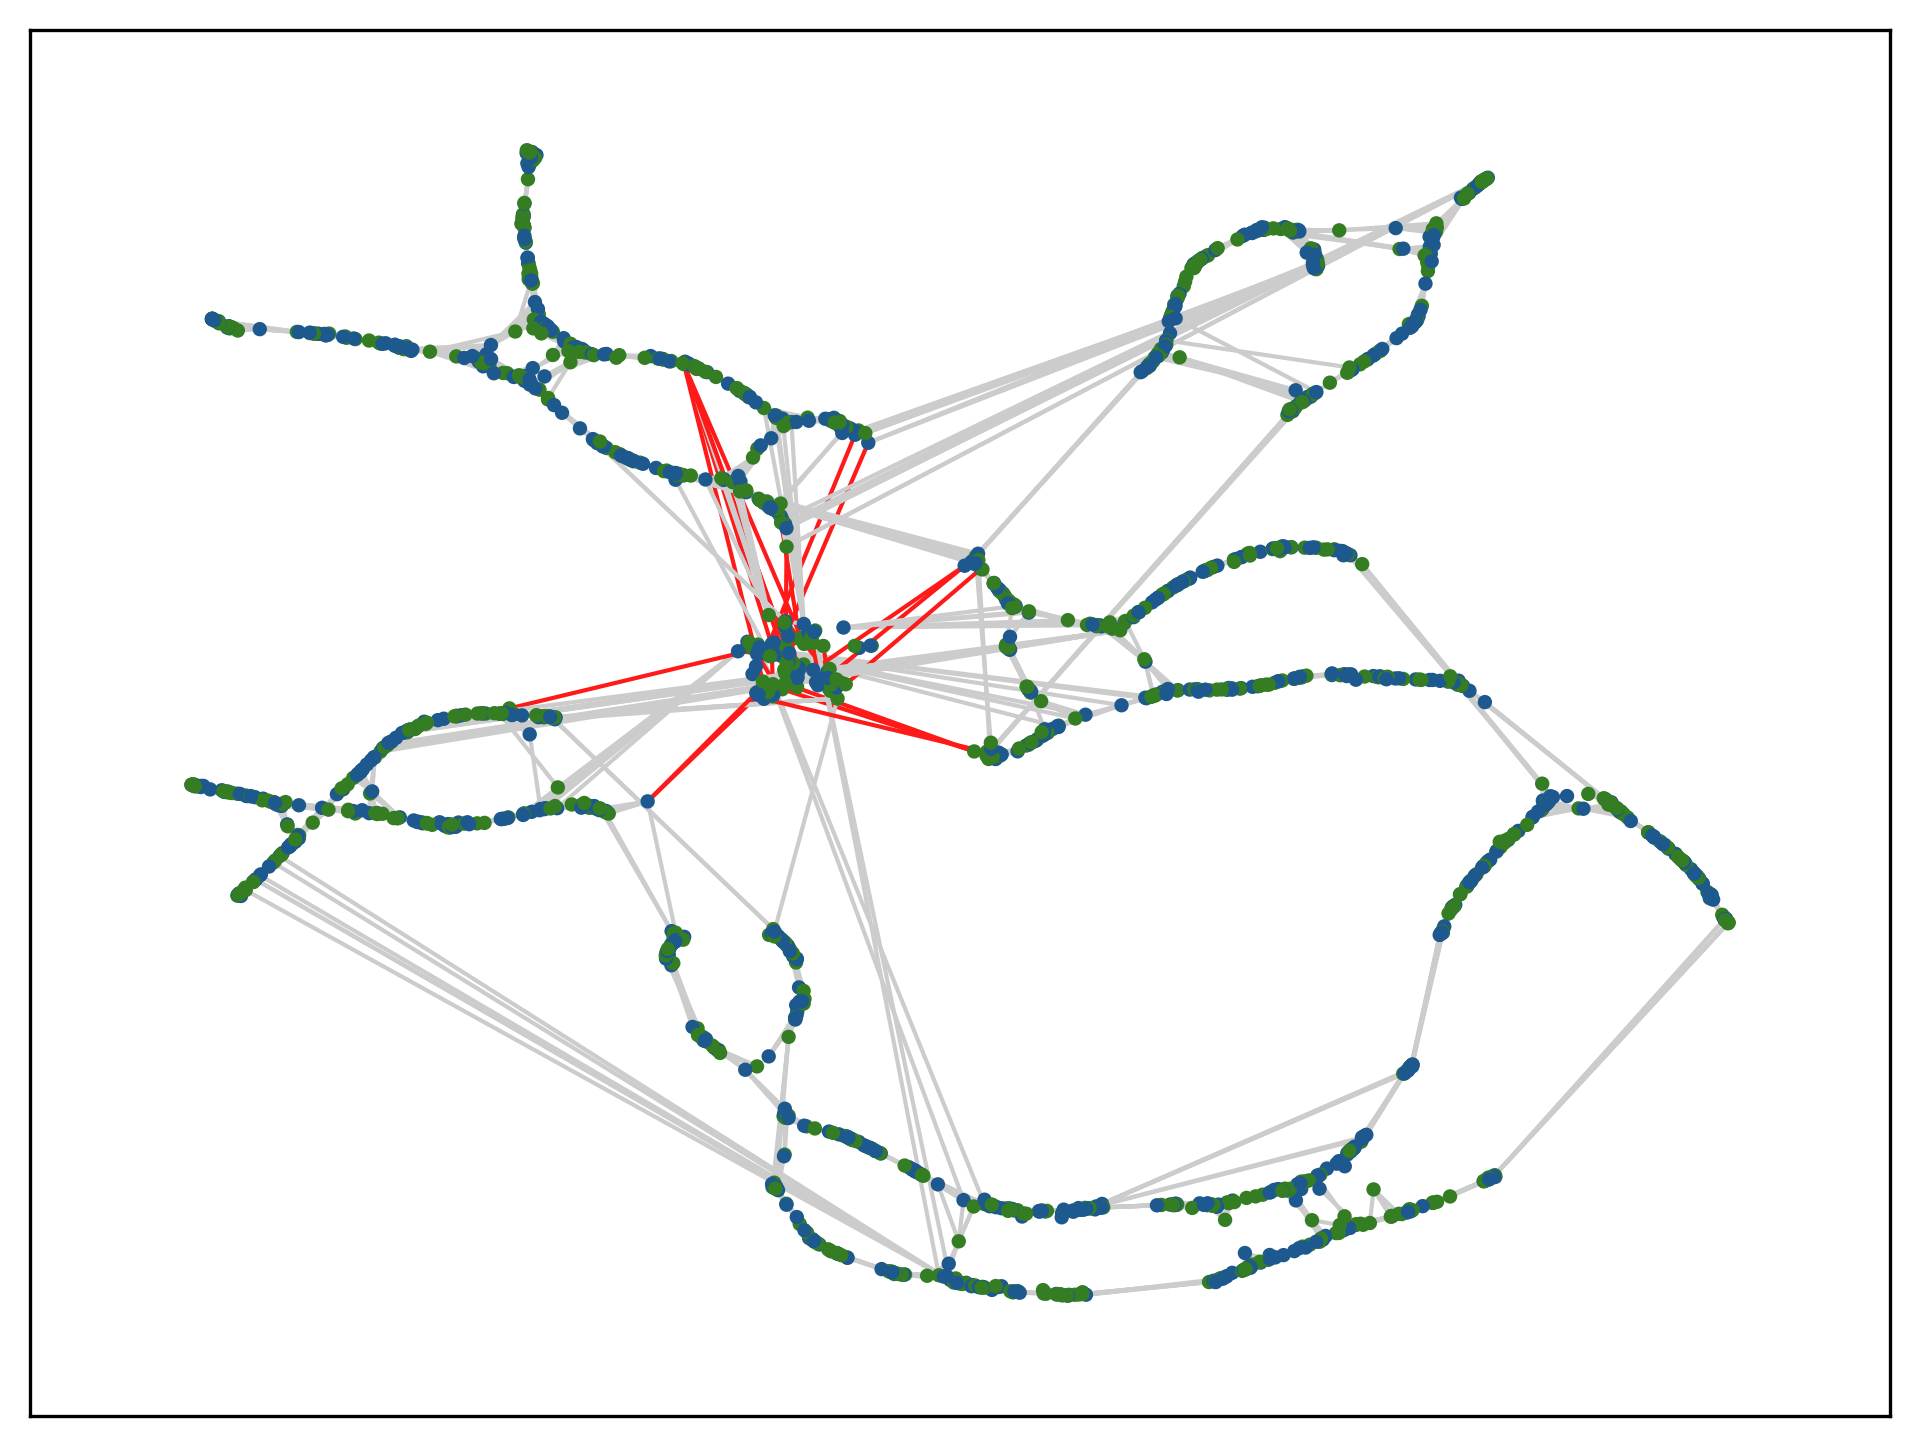

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx(
    read_graph,
    ax=ax,
    pos=pos_dict,
    with_labels=False,
    node_size=6,
    edge_color=edge_colors,
    node_color=node_colors,
)

In [159]:
def Umap_based_graph_embedding_concise(D_new, *, min_dist=1, random_state=1):
    mdata = ad.AnnData(obs=list(range(D_new.shape[0])))
    mdata.obsp["connectivities"] = D_new; 
 
    print('max connectivity (edge weight) ' + str(D_new.max()))
    if D_new.max() > 10:
        print("\033[0;33;40m", 'Warning:  the values of Connectivity Matrix (representing the weights) are too large', "\033[0m")
    mdata.uns["neighbors"] = {
        'connectivities_key': 'connectivities', 'params': {'method': 'umap'}}
    
    # sc.tl.paga(mdata)
    # sc.pl.paga(mdata,plot=False)
    # sc.tl.umap(mdata,init_pos='paga')
    sc.tl.umap(mdata, min_dist=min_dist, random_state=random_state)
    # sc.tl.umap(mdata,min_dist= 0.1)
    # sc.tl.umap(mdata,min_dist= 0.1,spread=5); # min_dist: "Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default."
    # sc.tl.umap(mdata,min_dist= 2,spread=4)
    embedding_D_new = mdata.obsm['X_umap']
    return embedding_D_new

In [119]:
G = read_graph
adj_matrix = nx.to_scipy_sparse_array(G)  
nodes = list(G.nodes)
for i in range(len(nodes)):
    for j in range(len(nodes)):
        node1, node2 = nodes[i], nodes[j]
        if G.has_edge(node1, node2):
            score = G[node1][node2]['alignment_score']
            adj_matrix[i, j] = score

In [149]:
G = read_graph
adj_matrix = nx.to_scipy_sparse_array(G)  
# nodes = list(G.nodes)
# for i in range(len(nodes)):
#     for j in range(len(nodes)):
#         node1, node2 = nodes[i], nodes[j]
#         if G.has_edge(node1, node2):
#             score = G[node1][node2]['alignment_score']
#             adj_matrix[i, j] = score

In [154]:
adj_matrix

<2010x2010 sparse array of type '<class 'numpy.int64'>'
	with 17068 stored elements in Compressed Sparse Row format>

In [155]:
embedding = Umap_based_graph_embedding_concise(adj_matrix)

max connectivity (edge weight) 1


In [156]:
pos_dict = {read: embedding[i] for i, read in enumerate(nodes)}

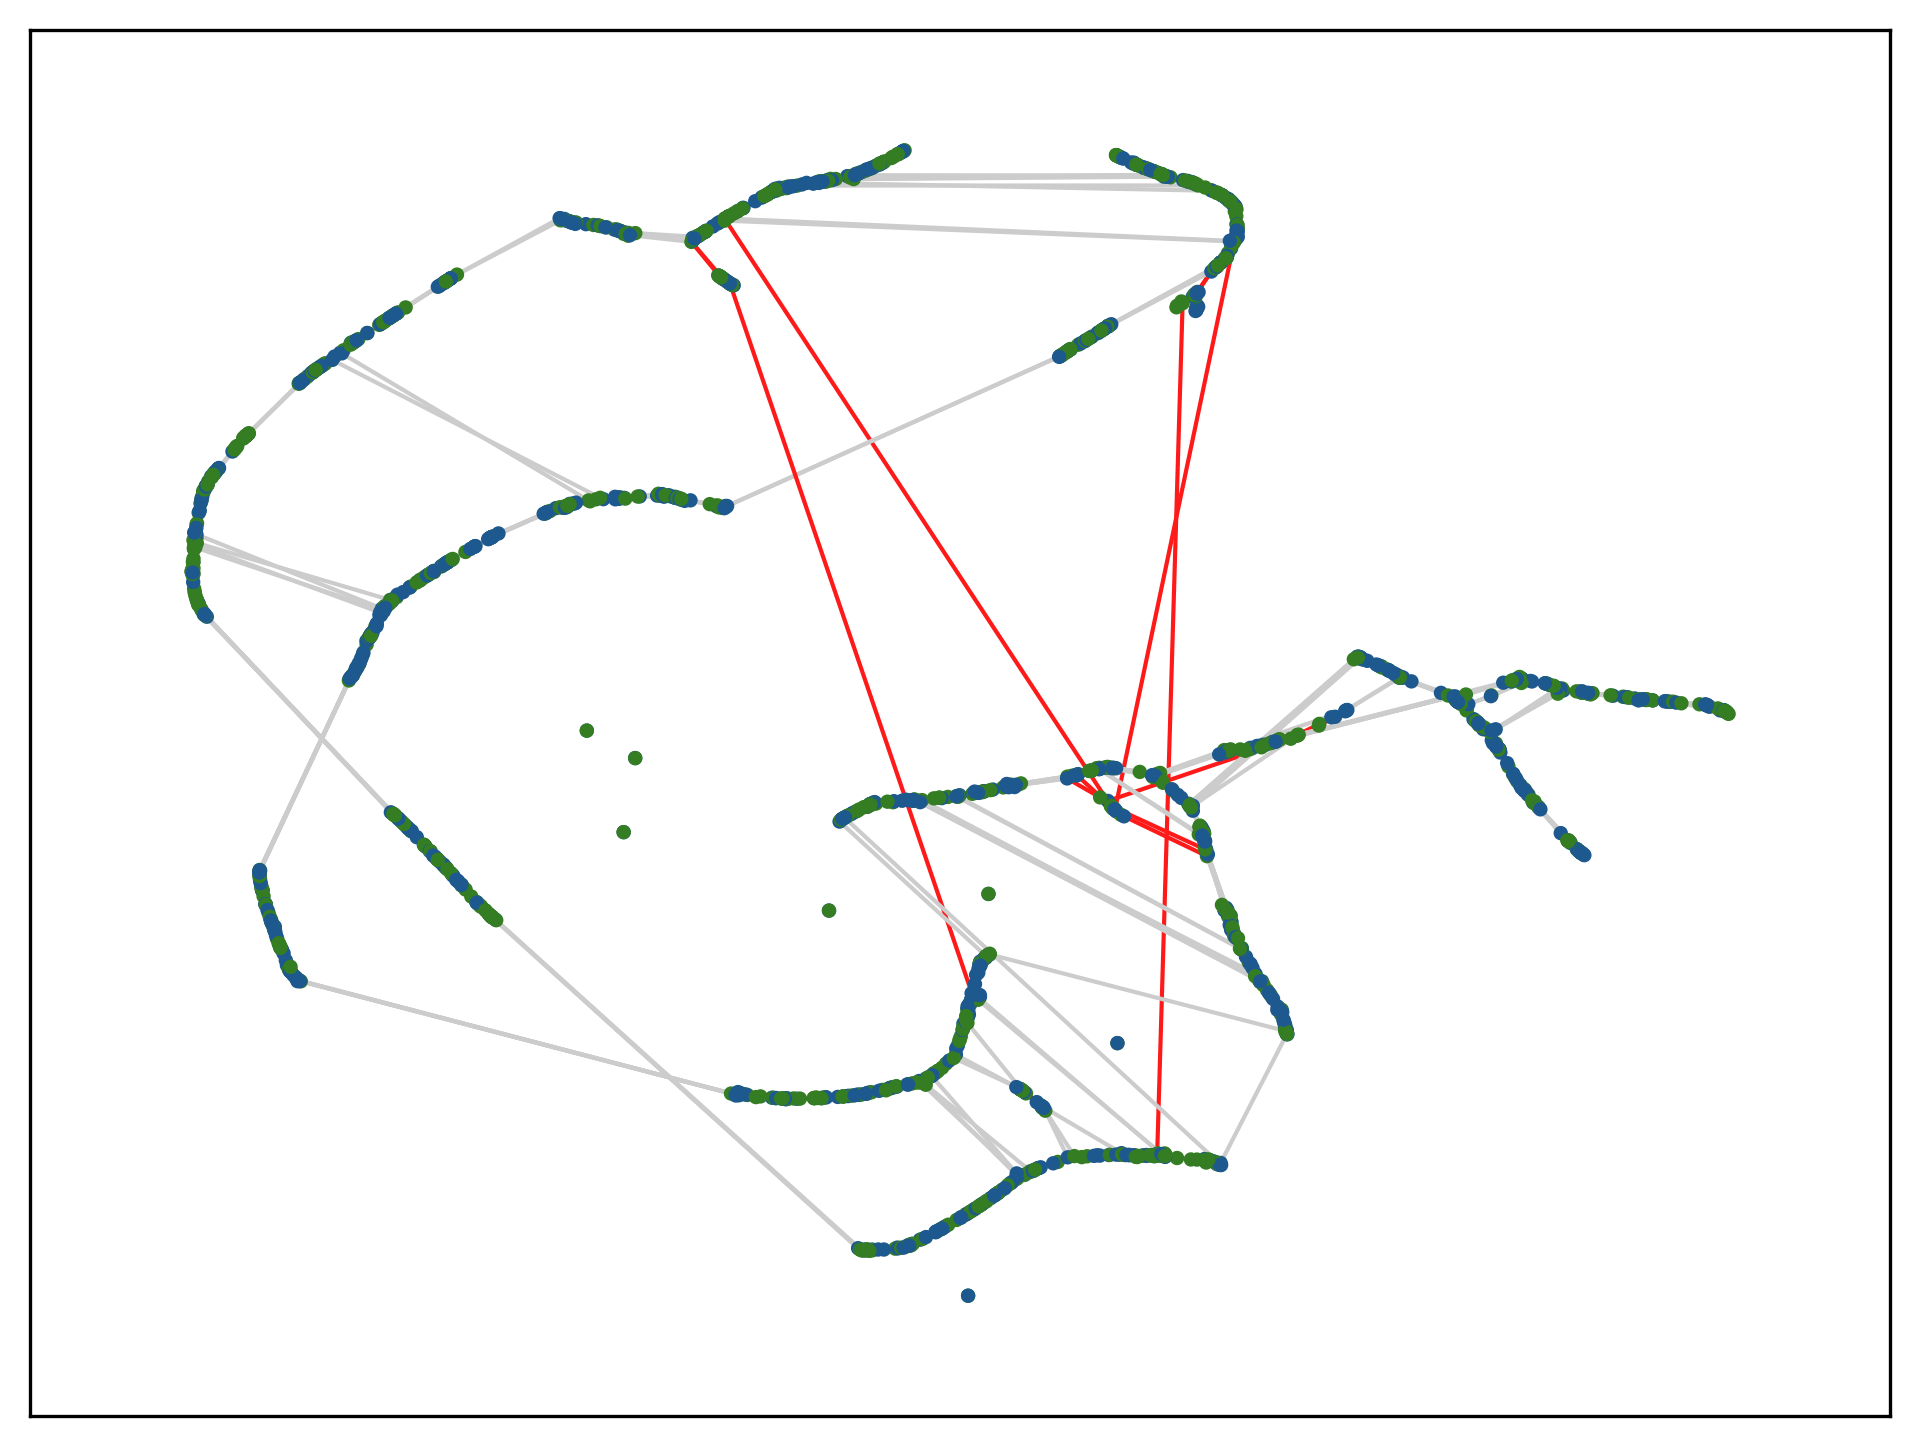

In [157]:
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx(
    read_graph,
    ax=ax,
    pos=pos_dict,
    with_labels=False,
    node_size=6,
    edge_color=edge_colors,
    node_color=node_colors,
)